In [50]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression

from datetime import datetime, timedelta
# from causallib.estimation import IPW

In [3]:
# 导入数据
def load_data_from_file(filename):
    with open(filename, 'rb') as handle:
        return pickle.load(handle)

# # 使用函数加载数据
# filename = "data/real_data_norm2.txt"  # 更改为您的文件名
# data = load_data_from_file(filename)
# print(list(data.keys()))

In [38]:
from causallib.datasets import load_nhefs

sample_data = load_nhefs()

In [62]:
learner = LogisticRegression(solver="liblinear")
ipw = IPW(learner)
ipw.fit(sample_data.X, sample_data.a)

IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(solver='liblinear'))

In [64]:
outcomes = ipw.estimate_population_outcome(sample_data.X, sample_data.a, sample_data.y)

In [70]:
sample_data.X

,age,race,sex,smokeintensity,smokeyrs,wt71,active_1,active_2,education_2,education_3,education_4,education_5,exercise_1,exercise_2,age^2,wt71^2,smokeintensity^2,smokeyrs^2
0,42,1,0,30,29,79.04,0,0,0,0,0,0,0,1,1764,6247.3216,900,841
1,36,0,0,20,24,58.63,0,0,1,0,0,0,0,0,1296,3437.4769,400,576
2,56,1,1,20,26,56.81,0,0,1,0,0,0,0,1,3136,3227.3761,400,676
3,68,1,0,3,53,59.42,1,0,0,0,0,0,0,1,4624,3530.7364,9,2809
4,40,0,0,20,19,87.09,1,0,1,0,0,0,1,0,1600,7584.6681,400,361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,47,0,1,20,31,84.94,0,0,0,0,0,0,0,0,2209,7214.8036,400,961
1624,45,0,0,40,29,63.05,0,0,0,0,0,0,0,0,2025,3975.3025,1600,841
1625,47,0,1,20,31,57.72,0,0,0,0,0,0,0,0,2209,3331.5984,400,961
1627,68,0,0,15,46,52.39,1,0,0,0,0,0,1,0,4624,2744.7121,225,2116


In [66]:
TREAT['conformity']

0         3
1         2
2         2
3         3
4         2
         ..
754995    3
754996    3
754997    3
754998    3
754999    3
Name: conformity, Length: 755000, dtype: int64

In [56]:
X.shape

(755000, 17)

## 统计方法尝试

In [4]:
filename = "data/sample5000_for_predict_logdiscrete.txt"
pred_data = load_data_from_file(filename)

In [6]:
print(pred_data['covariates'].shape)

(5000, 151, 14)


In [5]:
# 构建变量
# covariate_cols = ['gender','age','income3','weekday','sprtransp','spring','precip', 'voluntary']
# treatment_cols = ['conformity','restrict','open']
# outcome_col = 'move_distance'
covariate_cols = ['gender','age','income3','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4', 'weekday_5', 'weekday_6',
                  'sprtransp','spring','precip', 'voluntary']
treatment_cols = ['conformity_label0','conformity_label1','conformity_label2','conformity_label3','conformity_label4','restrict','open']
outcome_col = 'move_distance'

X = pd.DataFrame(pred_data['covariates'].reshape(-1,len(covariate_cols)), columns=covariate_cols)
TREAT = pd.DataFrame(pred_data['treatments'].reshape(-1,len(treatment_cols)), columns=treatment_cols)
X = pd.concat([X, TREAT[['restrict','open']]], axis=1)
Y = pd.DataFrame(pred_data['outcomes'].reshape(-1), columns=[outcome_col])
#W = pd.DataFrame(iptw.reshape(-1), columns=['iptw'])

ts = np.tile(np.arange(1, pred_data['outcomes'].shape[1]+1), pred_data['outcomes'].shape[0])
X['t']=ts
TREAT['t']=ts
Y['t']=ts
# ts = np.tile(np.arange(1, 151), 4005)
# W['t']=ts

In [6]:
mapping_dict = {
    tuple([1, 0, 0, 0, 0]): 0,
    tuple([1, 1, 0, 0, 0]): 1,
    tuple([1, 1, 1, 0, 0]): 2,
    tuple([1, 1, 1, 1, 0]): 3,
    tuple([1, 1, 1, 1, 1]): 4
}

# 应用映射
labeled_data = np.zeros(len(TREAT), dtype=int)  # 初始化一个新的数组
labels = TREAT[['conformity_label0','conformity_label1','conformity_label2','conformity_label3','conformity_label4']].values
for i in range(labels.shape[0]):
    labeled_data[i] = mapping_dict[tuple(labels[i])]

TREAT['conformity'] = labeled_data

In [32]:
X.head()

,gender,age,income3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,sprtransp,spring,precip,voluntary,restrict,open,t
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [25]:
from sklearn.linear_model import LogisticRegression
from causallib.estimation import IPW

# 计算每个时间点的处置效应
#results = np.zeros([pred_data['outcomes'].shape[1],5])
results = np.full((pred_data['outcomes'].shape[1],5), np.nan)
learner = LogisticRegression(solver="liblinear")
for t in range(1,pred_data['outcomes'].shape[1]+1):
    print(t)
    x = X[X['t']==t].reset_index(drop=True)
    x = x.drop('t',axis=1)
    a = TREAT[TREAT['t']==t].reset_index(drop=True)
    y = Y[Y['t']==t].reset_index(drop=True)
    #w = W[W['t']==t].reset_index(drop=True)
    
    ipw = IPW(learner)
    ipw = ipw.fit(x, a['conformity'])
    outcomes = ipw.estimate_population_outcome(x, a['conformity'], y['move_distance'])
    #print(len(outcomes))
    for i in outcomes.index:
        results[t-1,i] = outcomes[i]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151


In [33]:
samples = pred_data['outcomes'].shape[0]
timesteps = pred_data['outcomes'].shape[1]
# 按周汇总数据
# 创建一个日期范围
date_range = pd.date_range(start="2020-01-01", periods=timesteps)

# 为每个日期指定其所在的周
weeks = date_range.week

# 转换数据为长格式
df = pd.DataFrame({
    'week': weeks
})
df[['conformity_label0','conformity_label1','conformity_label2','conformity_label3','conformity_label4']] = results

# 根据标签和所在周进行分组，并计算均值
week_results = df.groupby('week').mean().values.T

/tmp/ipykernel_5368/2965448514.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  weeks = date_range.week


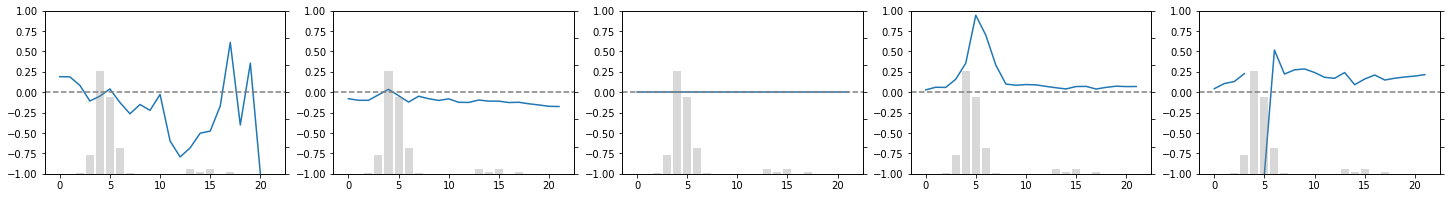

In [40]:
fig, ax = plt.subplots(1,5, figsize=(25,3))
for label in range(5):
    crd = (week_results[label,]-week_results[2,:])/week_results[2,:]
    ax[label].plot(crd)
    ax[label].axhline(0, color='grey', linestyle='--')  # 添加y=0的线
    ax[label].set_ylim([-1,1])
    
    # 创建共享x轴的第二y轴
    ax2 = ax[label].twinx()
    # 在第二y轴上绘制案例数据
    ax2.bar(np.arange(len(case_in_week)), case_in_week, color='grey', alpha=0.3)
    ax2.set_ylim([0, 300])  # 设置第二y轴的范围，你可以根据需要调整
    ax2.set_yticklabels([])
    #ax2.set_ylabel('Case')

In [18]:
learner = LogisticRegression(solver="liblinear")
ipw = IPW(learner)
COVARIATE = X.drop('t',axis=1)
ipw.fit(COVARIATE, TREAT['conformity'])
outcomes = ipw.estimate_population_outcome(COVARIATE, TREAT['conformity'], Y['move_distance'])
outcomes
# ate = ipw.estimate_population_outcome(x, a['conformity'], y['move_distance'], w=w['iptw'])
# #effect =  ipw.estimate_effect(ate[1], ate[0], effect_types=["ratio"])
# ATE.append(ate)

0    4.838525
1    5.091408
2    5.679151
3    6.470186
4    6.546537
dtype: float64

In [24]:
for i in outcomes.index:
    print(i)
    print(outcomes[i])

0
4.838524930288818
1
5.0914083984334075
2
5.6791513571217935
3
6.470185942616452
4
6.546537228847279


In [11]:
ipw.estimate_effect(outcomes[1], outcomes[0], effect_types=["diff"])

diff    0.252883
dtype: float64

In [12]:
outcomes[1]-outcomes[0]

0.2528834681445895

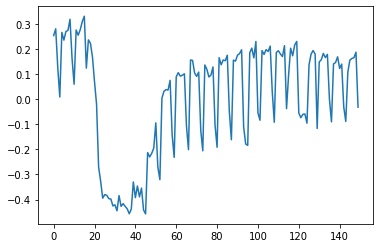

In [124]:
mean_ate = []
for ate in ATE:
    mean_ate.append(ate.mean())
plt.plot(np.arange(len(mean_ate)),mean_ate)

In [122]:
# 政策效应如何？
ipw = IPW(LogisticRegression())

restrict_potential_outcomes = ipw.estimate_population_outcome(_, TREAT['restrict'].loc[:4005*150-1], Y['move_distance'].loc[:4005*150-1], w=W['iptw'])
restrict_effect =  ipw.estimate_effect(restrict_potential_outcomes[1], restrict_potential_outcomes[0], effect_types=["diff"])
print(restrict_effect)

open_potential_outcomes = ipw.estimate_population_outcome(_, TREAT['open'].loc[:4005*150-1], Y['move_distance'].loc[:4005*150-1], w=W['iptw'])
open_effect =  ipw.estimate_effect(open_potential_outcomes[1], open_potential_outcomes[0], effect_types=["diff"])
print(open_effect)

diff   -0.454253
dtype: float64
diff    0.196121
dtype: float64


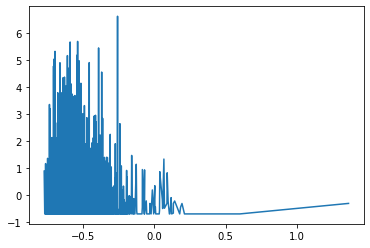

In [99]:
plt.plot(ATE[52])

In [163]:
observation = pd.DataFrame({'Y':Y['move_distance'].loc[:4005*150-1], 'A':TREAT['conformity'].loc[:4005*150-1], 'weight':W['iptw']})
observation.isnull().sum()

Y         0
A         0
weight    0
dtype: int64

In [165]:
observation['weight'] = observation['weight'].apply(lambda x: 0 if x<0 else x)
observation.head()

,Y,A,weight
0,-0.690954,-0.314151,1.000000
1,-0.291751,-0.471655,0.000000
2,2.390220,-0.329599,0.736089
3,1.138759,-0.485213,0.794778
4,-0.690954,-0.245341,0.896729


In [166]:
MSM_model = smf.wls(formula='Y ~ A', data=observation, weights=np.array(observation['weight'], dtype=np.float64)).fit()
#model = smf.ols(formula='Y ~ A', data=observation).fit()
print(MSM_model.summary())

                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.016
Model:                            WLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     9805.
Date:                Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                        19:37:03   Log-Likelihood:                   -inf
No. Observations:              600750   AIC:                               inf
Df Residuals:                  600748   BIC:                               inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0022      0.001      1.727      0.0

/root/miniconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:807: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


In [147]:
np.array(observation['weight'], dtype=np.float64)

array([ 1.        , -0.29527194,  0.73608872, ...,  0.99880715,
        0.99877698,  0.99878318])

In [149]:
df_observed['IPW'].min()

0.0

## 机器学习预测（离散化变量）

In [9]:
# 使用函数加载数据
filename = "results/real_data_results3/sample_10000_logdiscrete_control_gamma_0.6_prediction_log.txt"
data = load_data_from_file(filename)
for key in list(data.keys()):
    print(key)
    print(data[key].shape)

means
(5000, 151, 1)
upper_bounds
(5000, 151, 1)
lower_bounds
(5000, 151, 1)
labels
(5000, 151, 5)
observations
(5000, 151, 1)


In [114]:
unique_values, counts = np.unique(data['labels'], return_counts=True)

# 将结果打印为类似于 dataframe 的 value_counts 的格式
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

# 获取 ndarray 中的唯一值并进行排序
unique_values = np.sort(np.unique(data['labels']))
# 创建一个替换的映射
value_to_label = {value: label for label, value in enumerate(unique_values)}

# 使用 numpy 的 vectorize 函数应用映射
vectorized_func = np.vectorize(value_to_label.get)
labeled_data = vectorized_func(data['labels'])
labeled_data = labeled_data[:,:-1]

print(labeled_data)
print(labeled_data.shape)

-0.5291113660271073: 662601
0.8847027923807472: 170977
2.298516950788602: 50810
3.712331109196456: 19980
5.12614526760431: 1632
[[0 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 0 1 ... 0 0 1]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]
 [0 1 1 ... 2 2 2]]
(6000, 150)


In [4]:
# 创建映射字典
mapping_dict = {
    tuple([1, 0, 0, 0, 0]): 0,
    tuple([1, 1, 0, 0, 0]): 1,
    tuple([1, 1, 1, 0, 0]): 2,
    tuple([1, 1, 1, 1, 0]): 3,
    tuple([1, 1, 1, 1, 1]): 4
}

# 应用映射
labeled_data = np.zeros((data['labels'].shape[0], data['labels'].shape[1]), dtype=int)  # 初始化一个新的数组
for i in range(data['labels'].shape[0]):
    for j in range(data['labels'].shape[1]):
        labeled_data[i, j] = mapping_dict[tuple(data['labels'][i, j])]

labeled_data = labeled_data[:,:-1]
print(labeled_data.shape)

(5000, 150)


In [5]:
outcomes = data['means'].reshape(data['means'].shape[0], data['means'].shape[1])
uppers = data['upper_bounds'].reshape(data['means'].shape[0], data['means'].shape[1])
lowers = data['lower_bounds'].reshape(data['means'].shape[0], data['means'].shape[1])
observations = data['observations'].reshape(data['observations'].shape[0], data['observations'].shape[1])[:,:-1]
print(outcomes.shape)
print(observations.shape)

(5000, 150)
(5000, 150)


In [6]:
# 按从众类别求均值
# 初始化结果矩阵
label_counts = 5
samples = outcomes.shape[0]
timesteps = outcomes.shape[1]
results = np.zeros((label_counts, timesteps))

for t in range(timesteps):  # 遍历每个时间点
    for label in range(label_counts):  # 遍历每个标签
        mask = (labeled_data[:, t] == label)  # 创建一个掩码，表示哪些样本在当前时间点有此标签
        if np.sum(mask) > 0:  # 如果在当前时间点有任何样本具有此标签
            results[label, t] = np.mean(outcomes[mask, t])  # 计算均值并保存到结果矩阵中

In [7]:
# 按周汇总数据
# 创建一个日期范围
date_range = pd.date_range(start="2020-01-01", periods=timesteps)

# 为每个日期指定其所在的周
weeks = date_range.week

# 转换数据为长格式
df = pd.DataFrame({
    'week': np.tile(weeks, samples),
    'label': labeled_data.ravel(),
    'outcome': outcomes.ravel(),
    'upper':uppers.ravel(),
    'lower':lowers.ravel(),
    'observation':observations.ravel()
})

# 根据标签和所在周进行分组，并计算均值
results = df.groupby(['label', 'week']).outcome.mean().unstack()
upp_results = df.groupby(['label', 'week']).upper.mean().unstack()
low_results = df.groupby(['label', 'week']).lower.mean().unstack()
results = results.values
upp_results = upp_results.values
low_results = low_results.values

print(results)
print(results.shape)

/tmp/ipykernel_780/230018938.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  weeks = date_range.week


[[6.45949221 6.77933178 6.85017323 4.21135749 2.93837296 3.03380881
  3.67857545 4.78457398 5.66477579 5.69576814 5.8273334  5.73639475
  5.87418849 6.10658293 6.34447211 5.9899711  6.02813335 6.29999248
  6.32234988 6.41561089 6.36024846        nan]
 [6.67424562 6.62314608 6.71996167 4.08736408 2.94816895 3.04434679
  3.81042037 5.3235577  6.0925513  5.94369544 6.08111788 6.10282447
  6.17074708 6.03601933 6.08209337 5.99225846 6.0391486  5.98368438
  6.15249167 6.06340064 5.89673624 5.64199797]
 [6.92154656 6.77783406 6.79571857 4.41533721 3.43960834 3.95395012
  4.58231602 5.95835868 6.28028862 6.36478363 6.40867118 6.40285568
  6.36415624 6.19721367 6.47907523 6.4027986  6.39683118 6.20521839
  6.40825167 6.32141532 6.18039248 5.94256179]
 [7.15192934 7.09329314 7.06473006 5.69030627 4.10272588 4.96185589
  5.39799129 6.01382569 6.64389816 6.76399368 6.82405074 6.86253499
  6.75328422 6.46506364 6.77879099 6.84651573 6.86860076 6.46554071
  6.65531752 6.66461451 6.59449683 6.420252

In [47]:
results[:,-1]

array([0., 0., 0., 0., 0.])

In [2]:
# 导入病例数
case = pd.read_csv('data/case_series.csv')
case = case[case['date']>=20200101].reset_index(drop=True)
case = case[['date','voluntary']]
case['time'] = np.arange(len(case))
case['week'] = pd.to_datetime(case['date'].astype(str), format="%Y%m%d").dt.isocalendar().week
case.head()

,date,voluntary,time,week
0,20200101,0,0,1
1,20200102,0,1,1
2,20200103,0,2,1
3,20200104,0,3,1
4,20200105,0,4,1


In [3]:
case_in_week = case.groupby('week')['voluntary'].sum().values
case_in_week

array([  0,   0,   1,  35, 190, 142,  47,   2,   0,   0,   0,   0,   0,
         9,   4,   9,   0,   4,   0,   0,   0,   0])

Text(0, 0.5, 'covid cases')

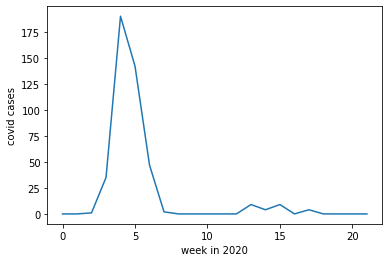

In [8]:
plt.plot(np.arange(len(case_in_week)), case_in_week)
plt.xlabel("week in 2020")
plt.ylabel("covid cases")

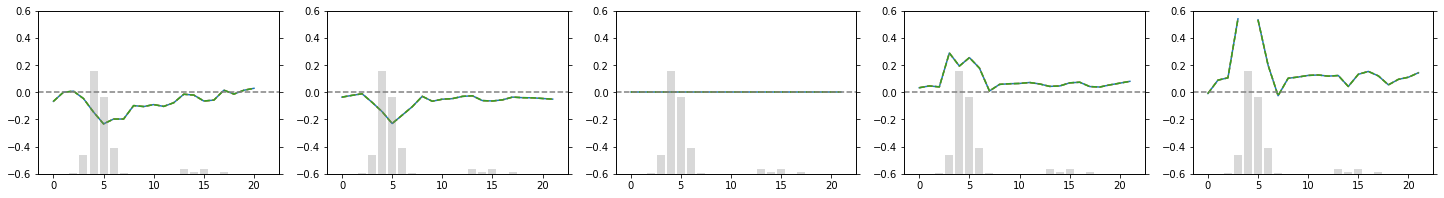

In [10]:
fig, ax = plt.subplots(1,5, figsize=(25,3))
for label in range(label_counts):
    crd = (results[label,]-results[2,:])/results[2,:]
    upp_crd = (upp_results[label,]-results[2,:])/results[2,:]
    low_crd = (low_results[label,]-results[2,:])/results[2,:]
    ax[label].plot(crd)
    ax[label].plot(upp_crd, linestyle='--')
    ax[label].plot(low_crd, linestyle='--')
    ax[label].axhline(0, color='grey', linestyle='--')  # 添加y=0的线
    ax[label].set_ylim([-0.6,0.6])
    
    # 创建共享x轴的第二y轴
    ax2 = ax[label].twinx()
    # 在第二y轴上绘制案例数据
    ax2.bar(np.arange(len(case_in_week)), case_in_week, color='grey', alpha=0.3)
    ax2.set_ylim([0, 300])  # 设置第二y轴的范围，你可以根据需要调整
    ax2.set_yticklabels([])
    #ax2.set_ylabel('Case')

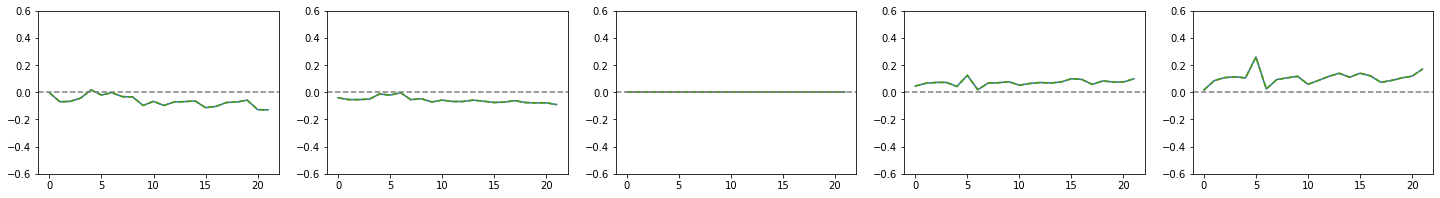

In [8]:
# 2019年对照组
fig, ax = plt.subplots(1,5, figsize=(25,3))
for label in range(label_counts):
    crd = (results[label,]-results[2,:])/results[2,:]
    upp_crd = (upp_results[label,]-results[2,:])/results[2,:]
    low_crd = (low_results[label,]-results[2,:])/results[2,:]
    ax[label].plot(crd)
    ax[label].plot(upp_crd, linestyle='--')
    ax[label].plot(low_crd, linestyle='--')
    ax[label].axhline(0, color='grey', linestyle='--')  # 添加y=0的线
    ax[label].set_ylim([-0.6,0.6])

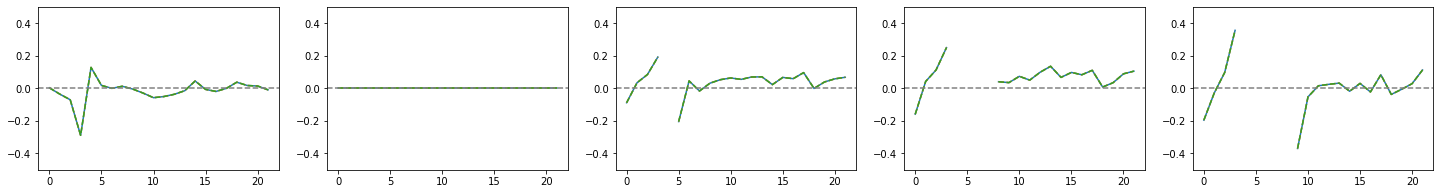

In [125]:
fig, ax = plt.subplots(1,5, figsize=(25,3))
for label in range(label_counts):
    crd = (results[label,]-results[1,:])/results[1,:]
    upp_crd = (upp_results[label,]-results[1,:])/results[1,:]
    low_crd = (low_results[label,]-results[1,:])/results[1,:]
    ax[label].plot(crd)
    ax[label].plot(upp_crd, linestyle='--')
    ax[label].plot(low_crd, linestyle='--')
    ax[label].axhline(0, color='grey', linestyle='--')  # 添加y=0的线
    ax[label].set_ylim([-0.5,0.5])

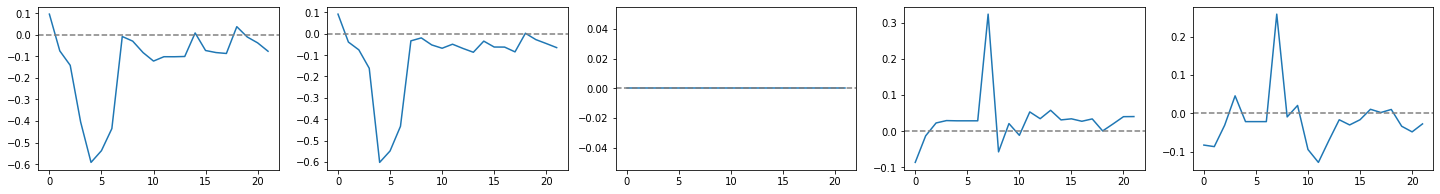

In [92]:
# 补全缺失值再显示一次
for i in range(results.shape[0]):
    row_mean = np.nanmean(results[i, :])
    results[i, np.isnan(results[i, :])] = row_mean

fig, ax = plt.subplots(1,5, figsize=(25,3))
for label in range(label_counts):
    crd = (results[label,]-results[2,:])/results[2,:]
    ax[label].plot(crd)
    ax[label].axhline(0, color='grey', linestyle='--')  # 添加y=0的线

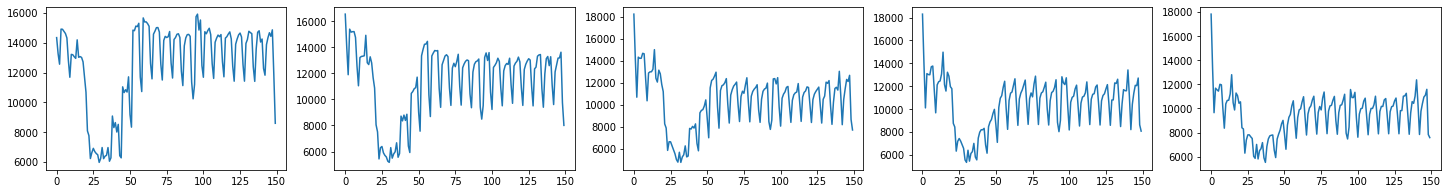

In [110]:
# 修改conformity取值后预测（每个class都有5000个样本）
# fig, ax = plt.subplots(1,5, figsize=(25,3))
df = pd.DataFrame({
    'week': weeks
})
for label in range(label_counts):
    filename = "results/real_data_results3/sample_10000_discrete_control_gamma_0.6_prediction" + str(label) + ".txt"
    data = load_data_from_file(filename)
    outcomes = data['means'].reshape(data['means'].shape[0], data['means'].shape[1])
    df['results'+str(label)] = np.mean(outcomes, axis=0)
    # ax[label].plot(np.mean(outcomes, axis=0))
    
results = df.groupby(['week']).mean()
results = results.values.T
print(results)
print(results.shape)

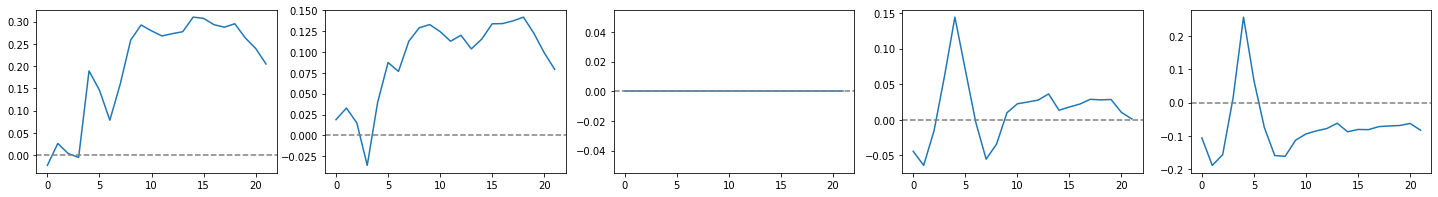

In [112]:
fig, ax = plt.subplots(1,5, figsize=(25,3))
for label in range(label_counts):
    crd = (results[label,]-results[2,:])/results[2,:]
    ax[label].plot(crd)
    ax[label].axhline(0, color='grey', linestyle='--')  # 添加y=0的线

## Dynamic Treatment Effects

In [61]:
# 导入iptw权重
iptw = np.load('results/rmsn_sample_10000_logdiscrete_control_gamma_0.6_use_confounders_True/propensity_scores_w_all.npy')
print(iptw.shape)

(5000, 150, 1)


In [62]:
df['iptw'] = iptw.ravel()
df.head()

,week,label,outcome,upper,lower,observation,iptw
0,1,3,6.886320,6.886320,6.886320,0.000000,1.000000
1,1,2,6.534663,6.534663,6.534663,0.000000,0.369808
2,1,2,6.331280,6.331280,6.331280,9.550876,0.601732
3,1,3,7.017721,7.017721,7.017721,11.446786,3.311974
4,1,2,6.635595,6.635595,6.635595,11.115592,0.553101


In [63]:
print(df['iptw'].isnull().sum())

0


In [69]:
# 计算动态处置效应
# 计算加权平均值的函数
def weighted_avg(group, avg_name, weight_name):
    d = group[avg_name]
    w = 1/group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

# 使用groupby按照'week'和'label'分组，并计算加权平均值
weighted_averages = df.groupby(['week', 'label']).apply(weighted_avg, 'observation', 'iptw')

# 重新排列结果，使其变成(num_labels, num_weeks)的二维结构
results = weighted_averages.unstack()

# 如果你想要得到一个numpy array而不是pandas DataFrame
results = results.values.T
print(results)
print(results.shape)

[[8.14668851e+00 4.27172039e+00 9.57152818e+00 1.29473809e-01
  4.89111402e+00 3.31332116e+00 6.57198936e+00 5.89150892e+00
  2.08782018e+00 1.41039250e+00 4.44300952e+00 1.40271531e+00
  1.18227070e+00 3.94648480e-04 1.47454706e-03 2.11647556e+00
  2.25751280e-01 9.04040924e+00 7.30234811e+00 9.07132896e+00
  0.00000000e+00            nan]
 [6.58047751e+00 7.34369704e+00 7.80011797e+00 4.17432398e+00
  3.33717467e+00 2.97503452e+00 3.71309810e+00 5.55676258e+00
  5.69224080e+00 5.42839847e+00 5.99911495e+00 5.74512088e+00
  5.50711886e+00 4.88172853e+00 6.61084459e+00 6.10034328e+00
  7.79003007e+00 4.74428812e+00 7.16437448e+00 6.10971358e+00
  5.84063982e+00 6.57782987e+00]
 [6.79259377e+00 6.89666874e+00 7.16403428e+00 4.47226741e+00
  3.45521455e+00 3.57754879e+00 4.10317375e+00 5.13083457e+00
  5.67995118e+00 5.63768357e+00 5.69337512e+00 5.70310507e+00
  6.07474067e+00 5.08659111e+00 6.62428336e+00 6.19728357e+00
  7.12825775e+00 5.77679464e+00 6.79947672e+00 6.10178674e+00
  5.

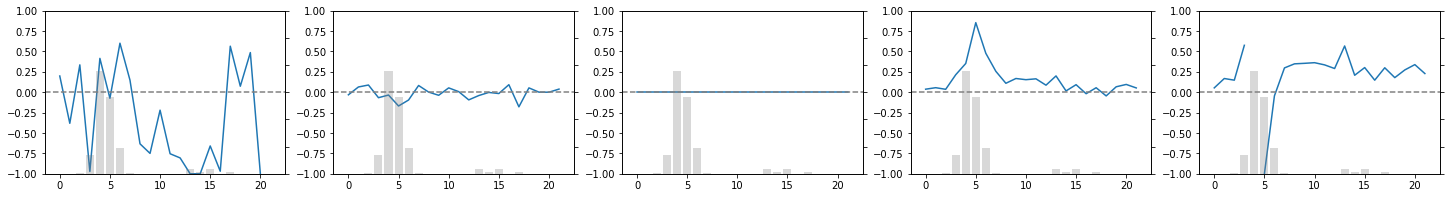

In [70]:
fig, ax = plt.subplots(1,5, figsize=(25,3))
for label in range(label_counts):
    crd = (results[label,]-results[2,:])/results[2,:]
    ax[label].plot(crd)
    ax[label].axhline(0, color='grey', linestyle='--')  # 添加y=0的线
    ax[label].set_ylim([-1,1])
    
    # 创建共享x轴的第二y轴
    ax2 = ax[label].twinx()
    # 在第二y轴上绘制案例数据
    ax2.bar(np.arange(len(case_in_week)), case_in_week, color='grey', alpha=0.3)
    ax2.set_ylim([0, 300])  # 设置第二y轴的范围，你可以根据需要调整
    ax2.set_yticklabels([])
    #ax2.set_ylabel('Case')

## ALE try

In [7]:
from functools import reduce
from itertools import product
from operator import add
from scipy.spatial import cKDTree

In [8]:
def _get_centres(x):
    return (x[1:] + x[:-1]) / 2

def _get_quantiles(train_set, feature, bins):
    if not isinstance(bins, (int, np.integer)):
        raise ValueError(
            "Expected integer 'bins', but got type '{}'.".format(type(bins))
        )
    quantiles = np.unique(
        np.quantile(
            train_set[feature], np.linspace(0, 1, bins + 1), interpolation="lower"
        )
    )
    bins = len(quantiles) - 1
    return quantiles, bins

from collections.abc import Iterable
def _parse_features(features):
    if isinstance(features, Iterable) and not isinstance(features, str):
        # If `features` is a non-string iterable.
        return np.asarray(features)
    else:
        # If `features` is not an iterable, or it is a string, then assume it
        # represents one column label.
        return np.asarray([features])

In [9]:
data = pd.read_csv("results/debug.csv")

quantiles_list = (np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22]), np.array([-6.23016330e+00, -1.62778674e+00, -1.25380511e+00, -1.00032233e+00,
       -8.03812814e-01, -6.37251449e-01, -4.92877233e-01, -3.60797178e-01,
       -2.37542124e-01, -1.18581402e-01, -1.86945372e-03,  1.14448910e-01,
        2.34633175e-01,  3.58560498e-01,  4.87908996e-01,  6.32399626e-01,
        7.96799568e-01,  1.00066138e+00,  1.28059417e+00,  1.70986196e+00,
        3.26232731e+00]))
bins_list = (22, 20)

index_groupby = data.groupby(["time", "index"])
train_set = data
data.head()

,time,index,effects
0,0,12,0.034547
1,0,12,0.063327
2,0,9,0.030874
3,0,12,0.001033
4,0,11,0.064007


Text(0, 0.5, 'predicted travel distance (km)')

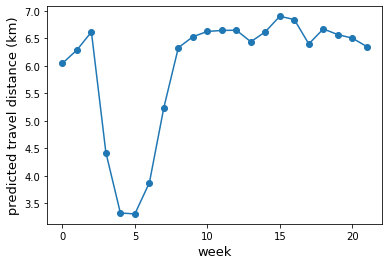

In [25]:
predict = pd.read_csv("results/predicions.csv")
mean_predict = predict.groupby("time")['predict'].mean()

plt.plot(mean_predict, marker='o')
plt.xlabel("week", fontsize=13)
plt.ylabel("predicted travel distance (km)", fontsize=13)

In [16]:
predict.head()

,time,index,predict
0,0,12,6.513204
1,0,12,6.423283
2,0,9,5.839942
3,0,12,5.608454
4,0,11,6.338270


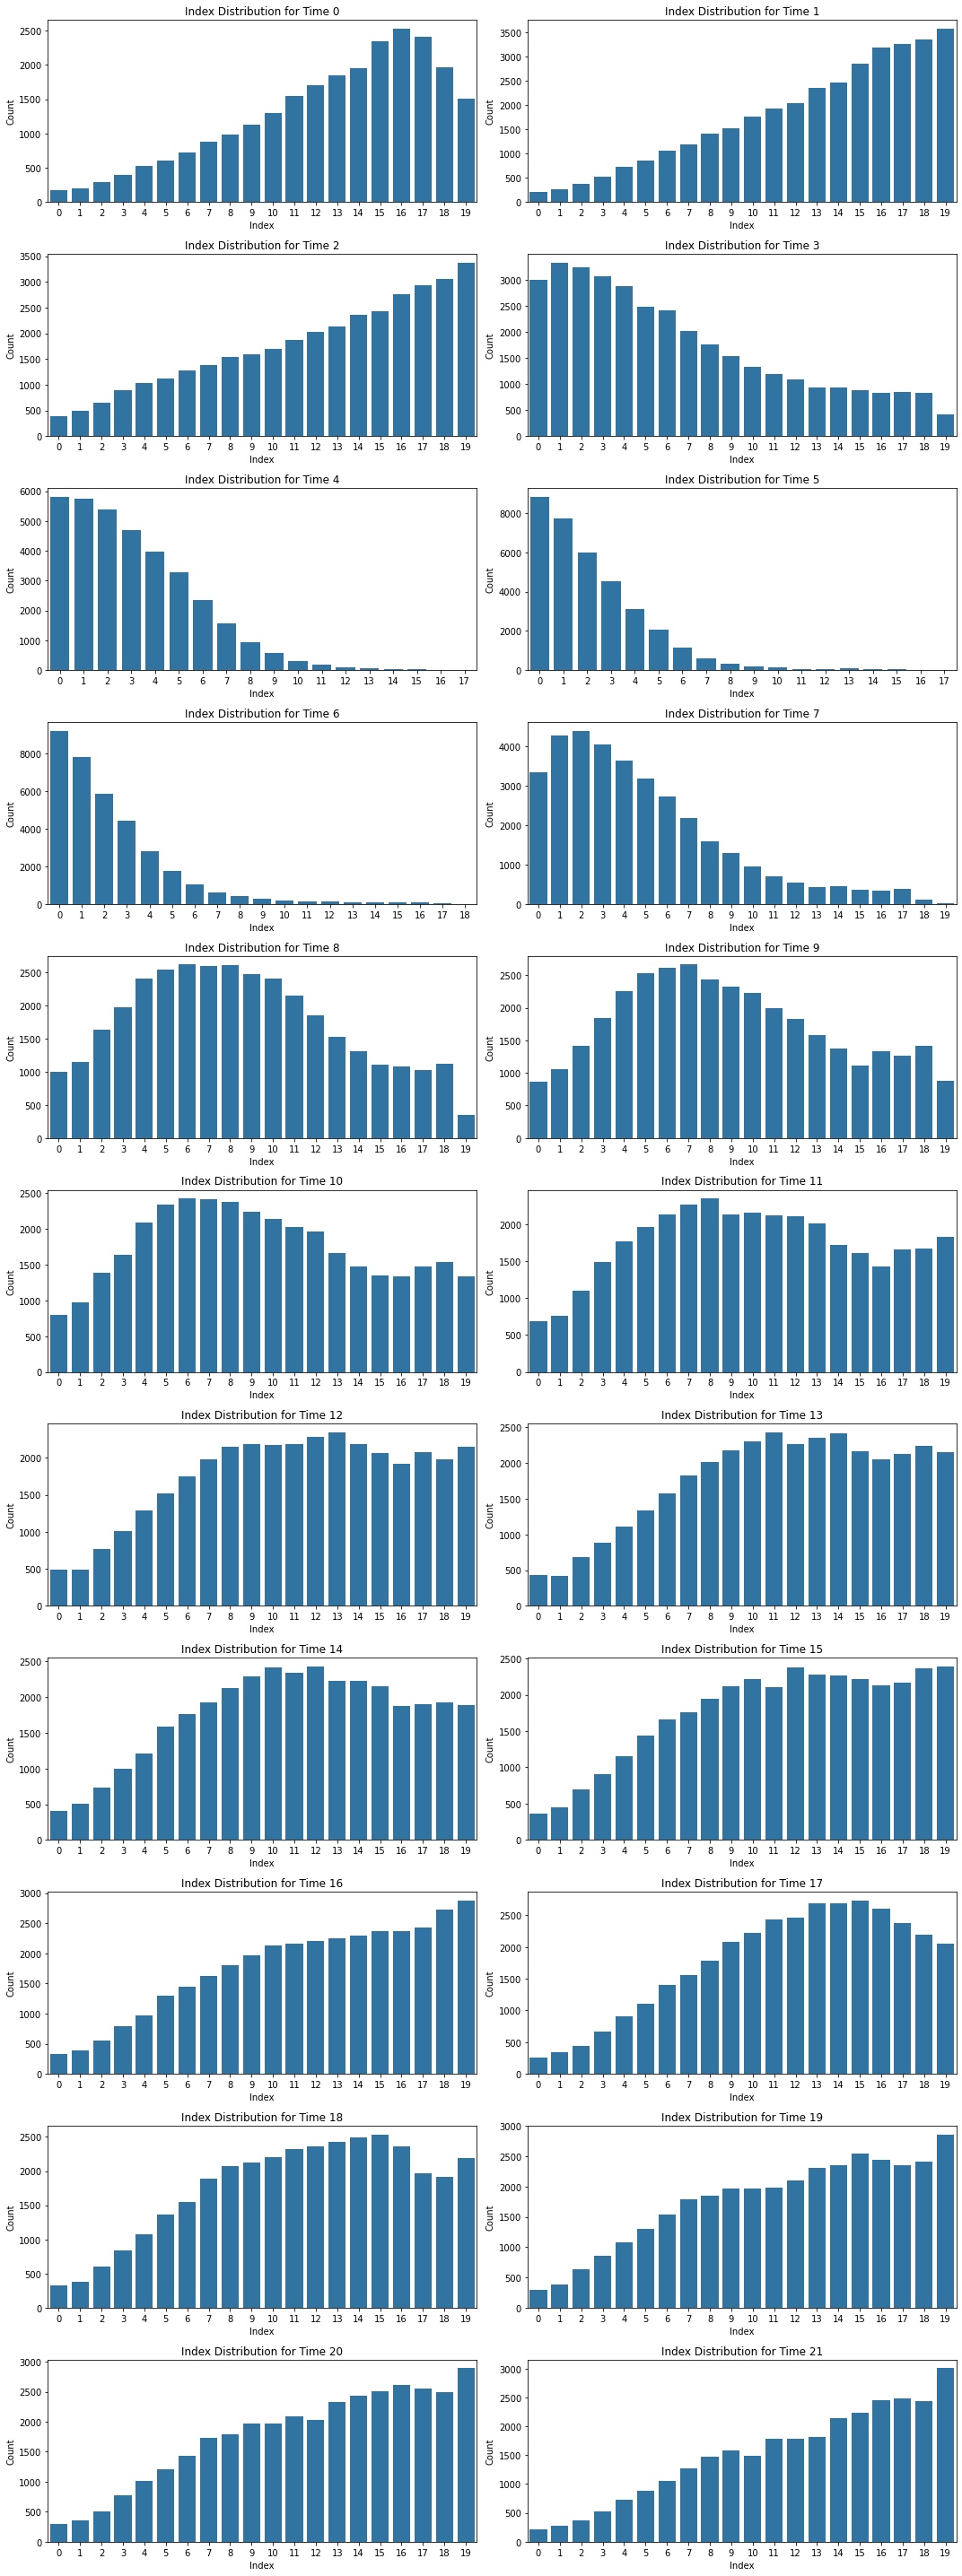

In [47]:
# 使用 plt.subplots 创建一个 22 个子图的图表
import seaborn as sns
fig, axes = plt.subplots(11, 2, figsize=(15, 40))  # 11行2列的子图布局
axes = axes.flatten()  # 将 axes 数组扁平化，以方便索引

for i, ax in enumerate(axes):
    # 对每个 time 值绘制图表
    sns.countplot(data=data[data['time'] == i], x='index', ax=ax)
    ax.set_title(f"Index Distribution for Time {i}")
    ax.set_xlabel("Index")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

fig.savefig("results/img/data_distribution.png")

In [14]:
mean_effects = index_groupby.mean().reset_index(drop=False)
mean_effects[mean_effects["time"]==0]

,time,index,effects
0,0,0,-1.124147
1,0,1,0.047474
2,0,2,0.096368
3,0,3,0.116282
4,0,4,0.096717
5,0,5,0.093090
6,0,6,0.082150
7,0,7,0.075965
8,0,8,0.064992
9,0,9,0.055542


In [45]:
compare_data = pd.read_csv("results/compare.csv")
quantiles_list = (np.array([-0.36462746, -0.24034135, -0.11605524,  0.25680308,  0.75394752,
        2.1210947 ,  7.09253902]), np.array([-6.23016330e+00, -1.62778674e+00, -1.25380511e+00, -1.00032233e+00,
       -8.03812814e-01, -6.37251449e-01, -4.92877233e-01, -3.60797178e-01,
       -2.37542124e-01, -1.18581402e-01, -1.86945372e-03,  1.14448910e-01,
        2.34633175e-01,  3.58560498e-01,  4.87908996e-01,  6.32399626e-01,
        7.96799568e-01,  1.00066138e+00,  1.28059417e+00,  1.70986196e+00,
        3.26232731e+00]))
bins_list = (6, 20)

index_groupby = compare_data.groupby(["index_0", "index_1"])
train_set = data
compare_data.head()

,index_0,index_1,effects
0,0,12,0.001084
1,0,12,0.003297
2,0,9,0.001514
3,0,12,-0.002167
4,0,11,0.000209


In [10]:
mean_effects = index_groupby.mean()
# Get the indices of the mean values.
group_indices = mean_effects.index

valid_grid_indices = tuple(zip(*group_indices))
# Extract only the data.
mean_effects = mean_effects.to_numpy().flatten()

# Get the number of samples in each bin.
n_samples = index_groupby.size().to_numpy()

# Create a 2D array of the number of samples in each bin.
samples_grid = np.zeros(bins_list)
samples_grid[valid_grid_indices] = n_samples

ale = np.ma.MaskedArray(
    np.zeros((len(quantiles_list[0]), len(quantiles_list[1]))),
    mask=np.ones((len(quantiles_list[0]), len(quantiles_list[1]))),
)
# Mark the first row/column as valid, since these are meant to contain 0s.
ale.mask[0, :] = False
ale.mask[:, 0] = False

# Place the mean effects into the final array.
# Since `ale` contains `len(quantiles)` rows/columns the first of which are
# guaranteed to be valid (and filled with 0s), ignore the first row and column.
ale[1:, 1:][valid_grid_indices] = mean_effects

In [11]:
# Record where elements were missing.
missing_bin_mask = ale.mask.copy()[1:, 1:]

if np.any(missing_bin_mask):
    # Replace missing entries with their nearest neighbours.

    # Calculate the dense location matrices (for both features) of all bin centres.
    centres_list = np.meshgrid(
        *(_get_centres(quantiles) for quantiles in quantiles_list), indexing="ij"
    )

    # Select only those bin centres which are valid (had observation).
    valid_indices_list = np.where(~missing_bin_mask)
    tree = cKDTree(
        np.hstack(
            tuple(
                centres[valid_indices_list][:, np.newaxis]
                for centres in centres_list
            )
        )
    )

    row_indices = np.hstack(
        [inds.reshape(-1, 1) for inds in np.where(missing_bin_mask)]
    )
    # Select both columns for each of the rows above.
    column_indices = np.hstack(
        (
            np.zeros((row_indices.shape[0], 1), dtype=np.int8),
            np.ones((row_indices.shape[0], 1), dtype=np.int8),
        )
    )

    # Determine the indices of the points which are nearest to the empty bins.
    nearest_points = tree.query(tree.data[row_indices, column_indices])[1]

    nearest_indices = tuple(
        valid_indices[nearest_points] for valid_indices in valid_indices_list
    )

    # Replace the invalid bin values with the nearest valid ones.
    ale[1:, 1:][missing_bin_mask] = ale[1:, 1:][nearest_indices]

In [12]:
features=["week", "c"]
week_index = features.index("week")
ale = np.cumsum(ale, axis=1-week_index)

if week_index == 0:
    # "week" 在第一个位置，对列应用 _get_centres
    ale = _get_centres(ale.T).T
    # 删除全0行或全0列
    ale = ale[1:,:]
    # 计算每行的加权平均值
    row_weighted_averages = np.sum(samples_grid * ale, axis=1) / np.sum(samples_grid, axis=1)
    # 从ale的每一行减去相应的加权平均值
    ale -= row_weighted_averages[:, np.newaxis]
else:
    # "week" 在第二个位置，对行应用 _get_centres
    ale = _get_centres(ale)
    ale=ale[:,1:]
    # 计算每列的加权平均值
    column_weighted_averages = np.sum(samples_grid * ale, axis=0) / np.sum(samples_grid, axis=0)
    # 从ale的每一列减去相应的加权平均值
    ale -= column_weighted_averages

# ale -= np.sum(samples_grid * ale) / train_set.shape[0]

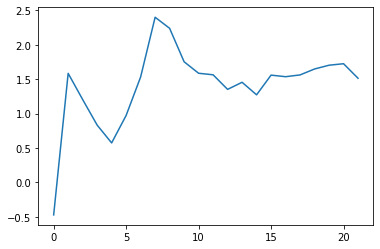

In [13]:
# 计算平均预测值(overall mean prediction)，应该直接用prediction[0]做加权平均
plt.plot(row_weighted_averages)

In [30]:
WEEK_EFFECTS = []
for week in np.sort(train_set["time"].unique()):
    n_samples = train_set[train_set["time"]==0].shape[0]
    week_effect = np.sum(samples_grid[week,:] * ale[week,:]) / n_samples
    WEEK_EFFECTS.append(week_effect)

In [40]:
WEEK_EFFECTS = []
for week in np.sort(train_set["time"].unique()):
    week_effect = np.mean(ale[week,:])
    WEEK_EFFECTS.append(week_effect)

Text(0, 0.5, 'Weighted average predicted trip distance')

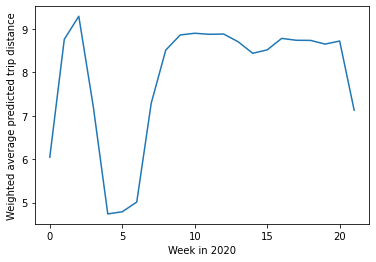

In [34]:
plt.plot(WEEK_EFFECTS)
plt.xlabel("Week in 2020")
plt.ylabel("Weighted average predicted trip distance")

Text(0, 0.5, 'Average predicted trip distance')

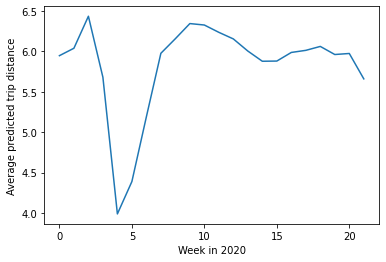

In [41]:
plt.plot(WEEK_EFFECTS)
plt.xlabel("Week in 2020")
plt.ylabel("Average predicted trip distance")

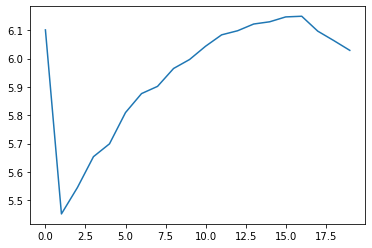

In [48]:
plt.plot(ale[0,:])

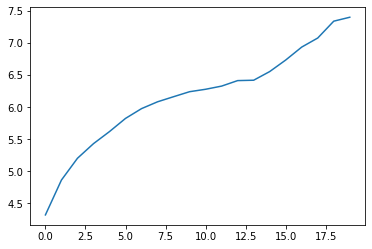

In [50]:
plt.plot(ale[8,:])

In [35]:
data = load_data_from_file('results/real_data_results3/sample_10000_log_gamma_0.6_dataset_with_substitute_confounders_for_predict.txt')
outcomes = data['outcomes']

In [36]:
samples = outcomes.shape[0]
timesteps = outcomes.shape[1]

date_range = pd.date_range(start="2020-01-01", periods=timesteps)
# 为每个日期指定其所在的周
weeks = date_range.week

# 转换数据为长格式
df = pd.DataFrame({
    'week': np.tile(weeks, samples),
    'outcome': outcomes.ravel()
})

/tmp/ipykernel_1206/3612768283.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  weeks = date_range.week


Text(0, 0.5, 'Average trip distance (km)')

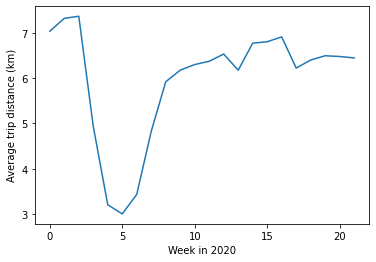

In [60]:
plt.plot(df.groupby("week").mean().to_numpy().flatten())
plt.xlabel("Week in 2020")
plt.ylabel("Average trip distance (km)")

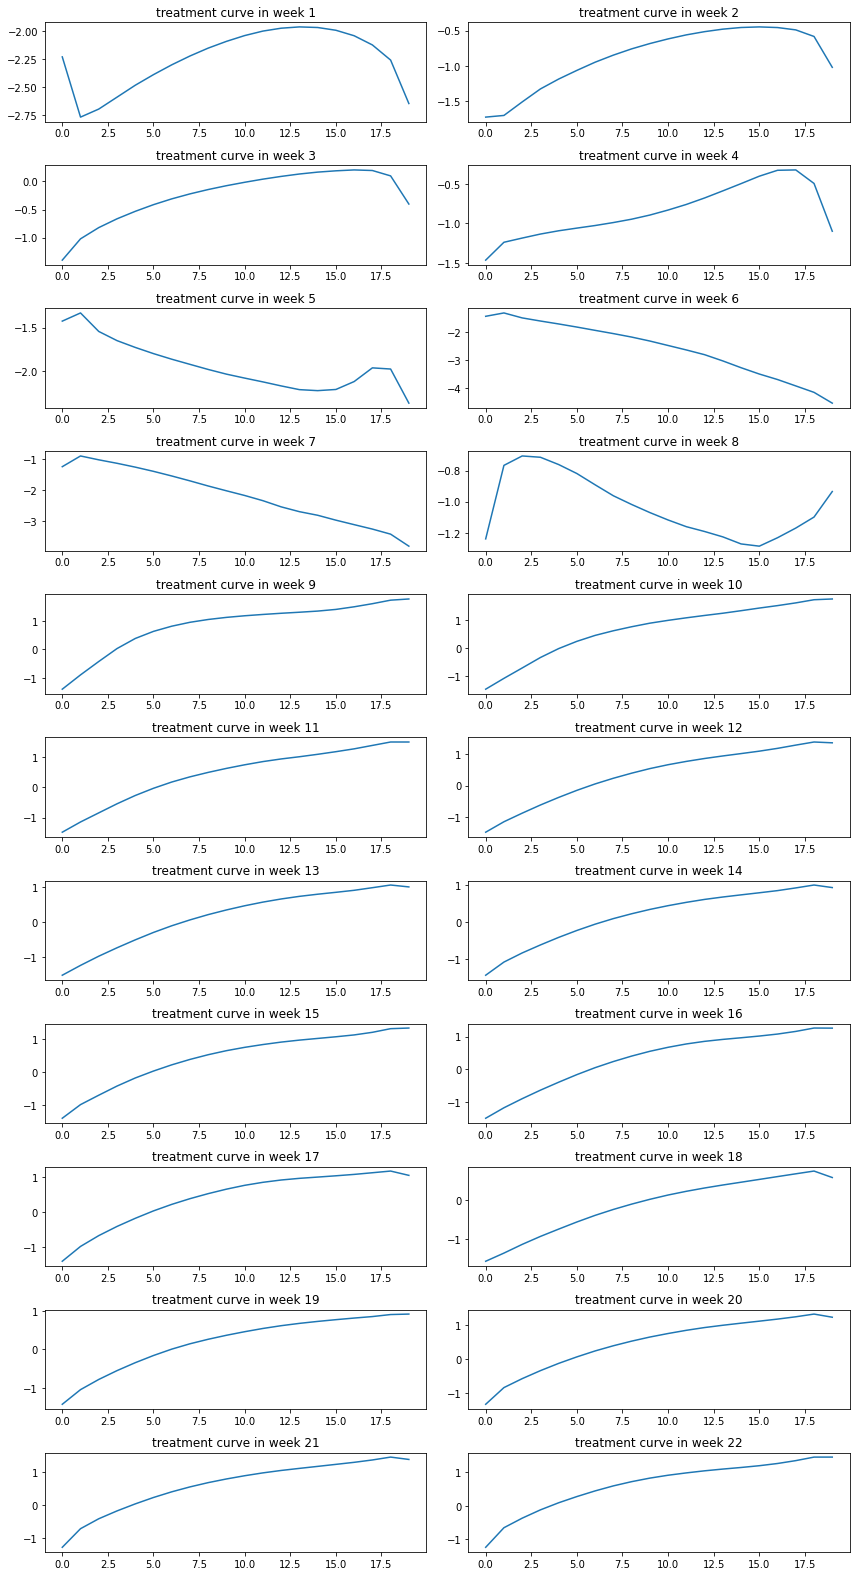

In [28]:
n_rows = 11
n_cols = 2

# Creating subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows))

# Plotting each row of data in a separate subplot
for i in range(22):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].plot(ale[i, :])
    axes[row, col].set_title(f'treatment curve in week {i+1}')

# Adjusting layout to prevent overlap
plt.tight_layout()

# Displaying the plot
plt.show()

fig.savefig("results/week_to_week_visual.png")

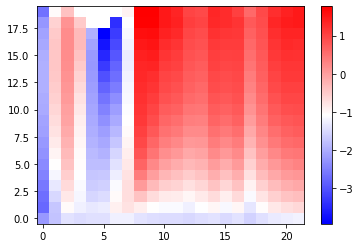

In [13]:
fig, ax = plt.subplots()
HM = ax.imshow(ale.T, aspect='auto', cmap="bwr", origin='lower')
fig.colorbar(HM)
plt.show()

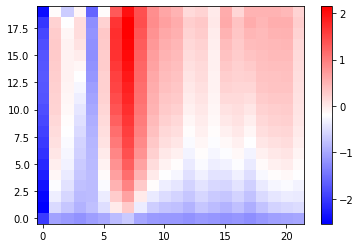

In [123]:
fig, ax = plt.subplots()
HM = ax.imshow(ale.T, aspect='auto', cmap="bwr", origin='lower')
fig.colorbar(HM)
plt.show()

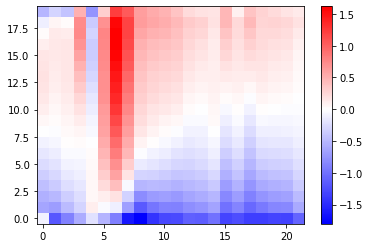

In [50]:
min_val = np.min(ale)
max_val = np.max(ale)

fig, ax = plt.subplots()
midpoint = abs(min_val) / (abs(max_val) + abs(min_val))
colors = [(0, "blue"), (midpoint, "white"), (1, "red")]
linear_cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)

HM = ax.imshow(ale.T, aspect='auto', cmap=linear_cmap, origin='lower', vmin=min_val, vmax=max_val)
# plt.colorbar()
fig.colorbar(HM)
plt.show()

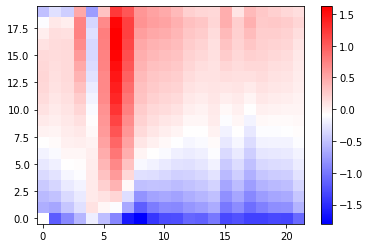

In [60]:
fig, ax = plt.subplots()

HM = ax.imshow(ale.T, aspect='auto', cmap='bwr', origin='lower')
# plt.colorbar()
fig.colorbar(HM)
plt.show()

In [9]:
# 尝试3D图
from mpl_toolkits.mplot3d import Axes3D

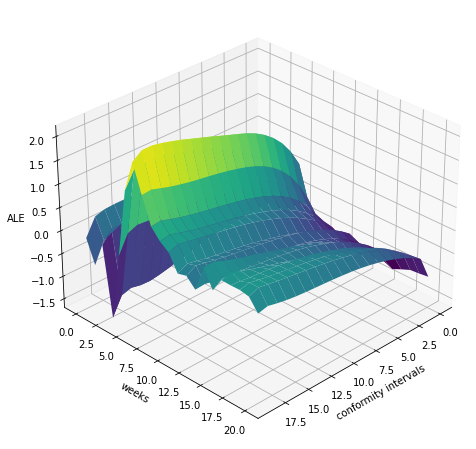

In [11]:
# 创建X和Y坐标网格
x = np.arange(ale.shape[1])
y = np.arange(ale.shape[0])
X, Y = np.meshgrid(x, y)

# 创建图形和轴
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制曲面图
surf = ax.plot_surface(X, Y, ale, cmap='viridis', edgecolor='none')

# 设置标签
ax.set_xlabel('conformity intervals')
ax.set_ylabel('weeks')
ax.set_zlabel('ALE')

# 添加颜色条
# fig.colorbar(surf)

# 设置视角 (俯视角度elev, 方位角度azim)
ax.view_init(elev=30, azim=45)  # 可以根据需要调整视角

plt.show()

### 数据分布情况

In [51]:
data = pd.read_csv("results/data_dist_check.csv")
data.head()

,time,index,conformity
0,0,12,0.241770
1,0,12,0.301088
2,0,9,-0.044729
3,0,12,0.273015
4,0,11,0.233031


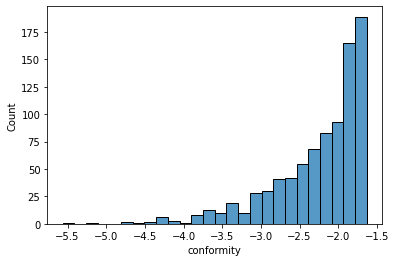

In [57]:
weird_data = data.query("time==9 and index==0")
sns.histplot(weird_data['conformity'], kde=False)
plt.show()

In [72]:
pdp_array = np.load("results/pdp_array.npy")
pdp_array.shape

(21, 755000)

In [73]:
pdp_array = _get_centres(pdp_array)

In [75]:
WEEK_EFFECTS = []
for week in np.sort(train_set["time"].unique()):
    n_samples = train_set[train_set["time"]==0].shape[0]
    week_indices = train_set['time'] == week
    pdp_in_week = pdp_array[:, week_indices]
    mean_pdp = np.mean(pdp_array, axis=1)
    week_effect = np.sum(samples_grid[week,:] * mean_pdp) / n_samples
    WEEK_EFFECTS.append(week_effect)

Text(0, 0.5, 'Average predicted trip distance')

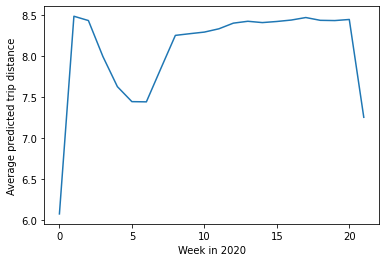

In [78]:
plt.plot(WEEK_EFFECTS)
plt.xlabel("Week in 2020")
plt.ylabel("Average predicted trip distance")

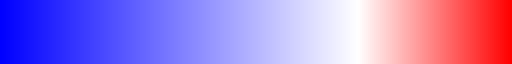

In [15]:

colors = [(0, "blue"), (0.7, "white"), (1, "red")]
linear_cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)
linear_cmap

### 多分类的ALE

In [2]:
from rmsn.script_rnn_predict import rnn_predict
from feature_engineer import Feature_Engineering
from utils.evaluation_utils import load_data
import copy
import gc

2024-04-02 16:20:29.839774: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-02 16:20:29.875484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 16:20:30.521968: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2024-04-02 16:20:31.622022: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
2024-04-02 16:20:31.622815: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22288 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:02:00.0, compute capability: 8.9
2024-04-02 16:20:31.623434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22288 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:03:00.0, compute capability: 8.9
2024-04-02 16:20:31.623999: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22288 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 4090

Number of devices: 4


In [3]:
MODEL_ROOT = "results/rmsn_all_data_v2_use_confounders_True"

#### 数据处理

In [4]:
# dataset = load_data("results/tf2_test_dataset_with_substitute_confounders.txt")
dataset = load_data("../data/all_data_dataset_with_substitute_confounders.h5")
FE = Feature_Engineering(dataset, for_factor_model = False)
dataset = FE.dataset

In [5]:
# 使用2020年数据
column_index = 13  # index of year 2020 indicator
selected_indices = np.where(dataset['covariates'][:, :, column_index] == 1)[0]
unique_selected_indices = np.unique(selected_indices)
for key in dataset.keys():
    print(key)
    dataset[key] = dataset[key][unique_selected_indices]

covariates
outcomes
predicted_confounders
previous_covariates
previous_treatments
sequence_length
treatments


In [6]:
num_samples, length, num_covariates = dataset['covariates'].shape
_, _, num_treatments = dataset['treatments'].shape
FE.get_normalize_params(dataset, num_covariates, num_treatments)
scale_params = FE.scale_params
dataset['output_means'] = scale_params['outcomes'][:, 0]
dataset['output_stds'] = scale_params['outcomes'][:, 1]

dataset = FE.get_dataset_normalize(dataset, num_covariates, num_treatments)

#### 修改treatment预测

In [6]:
conformity_index = 0
indices = np.unique(dataset['treatments'][...,0])
indices

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.], dtype=float32)

In [7]:
# 第一次预测，原数据
prediction, observations = rnn_predict(dataset=dataset, MODEL_ROOT=MODEL_ROOT,
                    b_use_predicted_confounders=True)

INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 0it [00:00, ?it/s]2024-04-01 15:21:27.151451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
Predicting rnn_propensity_weighted: 15339it [08:24, 30.39it/s]


In [8]:
# 第二次预测，treatment + 1
dataset_replic = copy.deepcopy(dataset)
dummy_treat = dataset_replic['treatments'][:,:,conformity_index]
dummy_treat = np.clip(dummy_treat+1, None, np.max(dummy_treat))
dataset_replic['treatments'][:,:,conformity_index] = dummy_treat
prediction_plus, _ = rnn_predict(dataset=dataset_replic, MODEL_ROOT=MODEL_ROOT,
                    b_use_predicted_confounders=True)
del dataset_replic
gc.collect()

INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 15339it [07:04, 36.12it/s]


52445

In [11]:
# 第三次预测，treatment - 1
dataset_replic = copy.deepcopy(dataset)
dummy_treat = dataset_replic['treatments'][:,:,conformity_index]
dummy_treat = np.clip(dummy_treat-1, np.min(dummy_treat), None)
dataset_replic['treatments'][:,:,conformity_index] = dummy_treat
prediction_minus, _ = rnn_predict(dataset=dataset_replic, MODEL_ROOT=MODEL_ROOT,
                    b_use_predicted_confounders=True)
del dataset_replic
gc.collect()

INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 5113it [02:22, 35.86it/s]


49479

(0.4, 0.8)

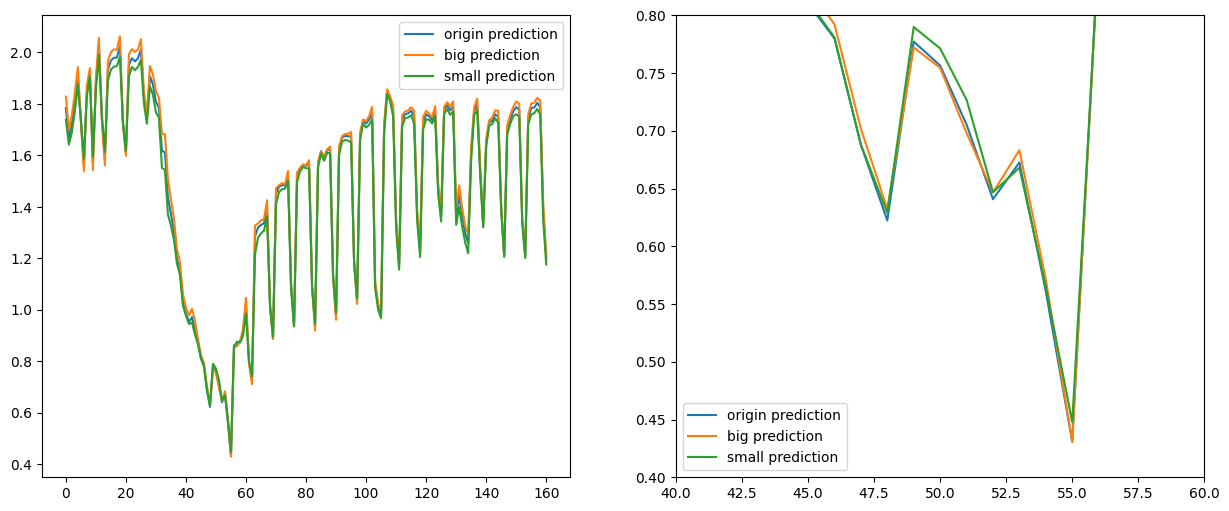

In [29]:
# 2020年平均预测
fig, ax = plt.subplots(1,2,figsize=(15, 6))
ax[0].plot(np.mean(prediction, axis=0), label="origin prediction")
ax[0].plot(np.mean(prediction_plus, axis=0), label="big prediction")
ax[0].plot(np.mean(prediction_minus, axis=0), label="small prediction")
ax[0].legend()

ax[1].plot(np.mean(prediction, axis=0), label="origin prediction")
ax[1].plot(np.mean(prediction_plus, axis=0), label="big prediction")
ax[1].plot(np.mean(prediction_minus, axis=0), label="small prediction")
ax[1].legend()
ax[1].set_xlim([40,60])
ax[1].set_ylim([0.4, 0.8])

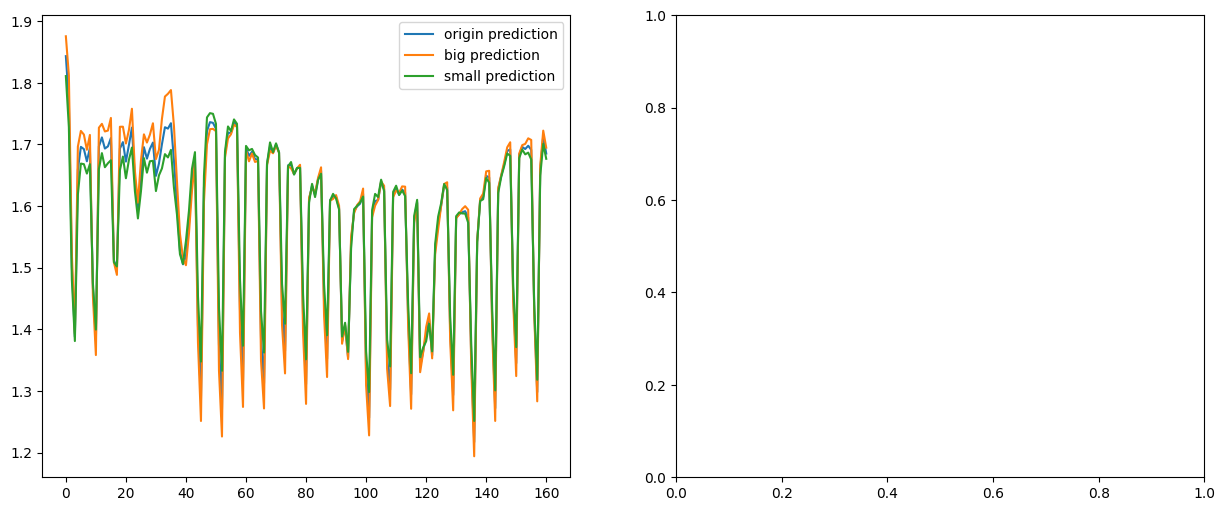

In [12]:
# 2019年平均预测
fig, ax = plt.subplots(1,2,figsize=(15, 6))
ax[0].plot(np.mean(prediction, axis=0), label="origin prediction")
ax[0].plot(np.mean(prediction_plus, axis=0), label="big prediction")
ax[0].plot(np.mean(prediction_minus, axis=0), label="small prediction")
ax[0].legend()

# ax[1].plot(np.mean(prediction, axis=0), label="origin prediction")
# ax[1].plot(np.mean(prediction_plus, axis=0), label="big prediction")
# ax[1].plot(np.mean(prediction_minus, axis=0), label="small prediction")
# ax[1].legend()
# ax[1].set_xlim([40,60])
# ax[1].set_ylim([0.4, 0.8])

In [9]:
effects = prediction_plus- prediction
index_groupby = pd.DataFrame({"index": dataset['treatments'][:,:,conformity_index].flatten(), "effects": effects.flatten()}).groupby(
        "index")
mean_effects = index_groupby.mean().to_numpy().flatten()
ale = np.array([0, *np.cumsum(mean_effects)])
ale = (ale[1:] + ale[:-1]) / 2
ale -= np.sum(ale * index_groupby.size() / (num_samples*length))

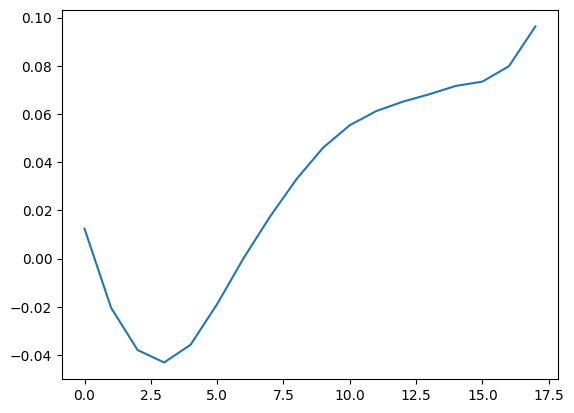

In [50]:
plt.plot(ale)

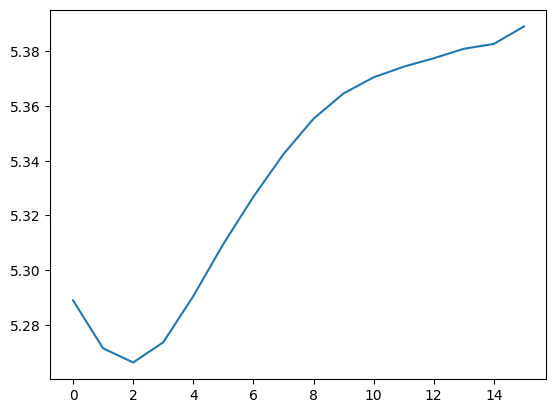

In [13]:
# 2020
plt.plot(ale[1:-1])

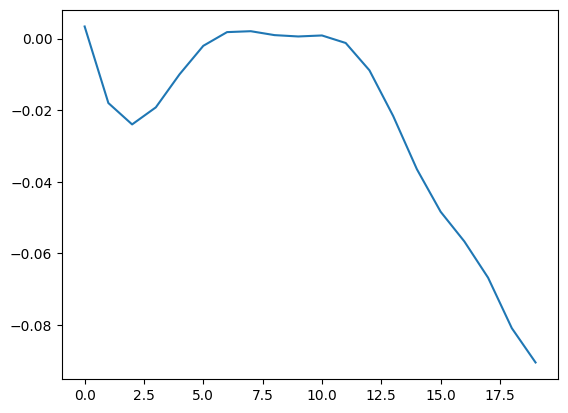

In [14]:
# 2019
plt.plot(ale)

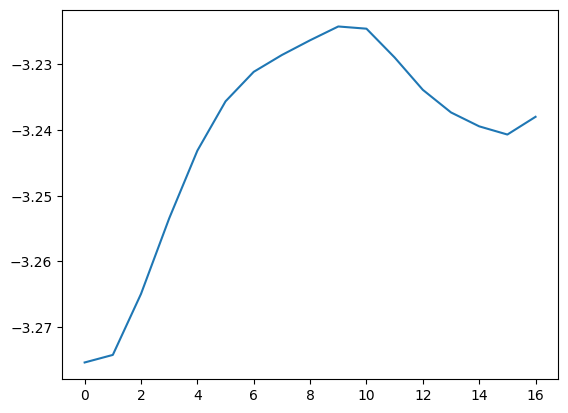

In [33]:
# 2023
plt.plot(ale[1:-1])

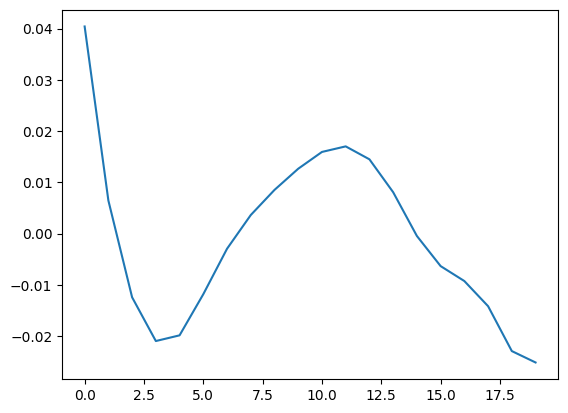

In [10]:
plt.plot(ale)

#### 加入时间维度的ALE

In [43]:
# 先用prediction, prediction_plus, prediction_minus试试
effects = prediction_plus- prediction
ALE = []
for i in range(0, length, 7):
    start = i
    end = i+7 if i+7<length else length
    
    index_groupby = pd.DataFrame({"index": dataset['treatments'][:,start:end,conformity_index].flatten(), 
                                  "effects": effects[:,start:end].flatten()}).groupby("index")
    mean_effects = index_groupby.mean().to_numpy().flatten()
    ale = np.array([0, *np.cumsum(mean_effects)])
    ale = (ale[1:] + ale[:-1]) / 2
    ale -= np.sum(ale * index_groupby.size() / (index_groupby.size().sum()))
    
    ALE.append(ale)          

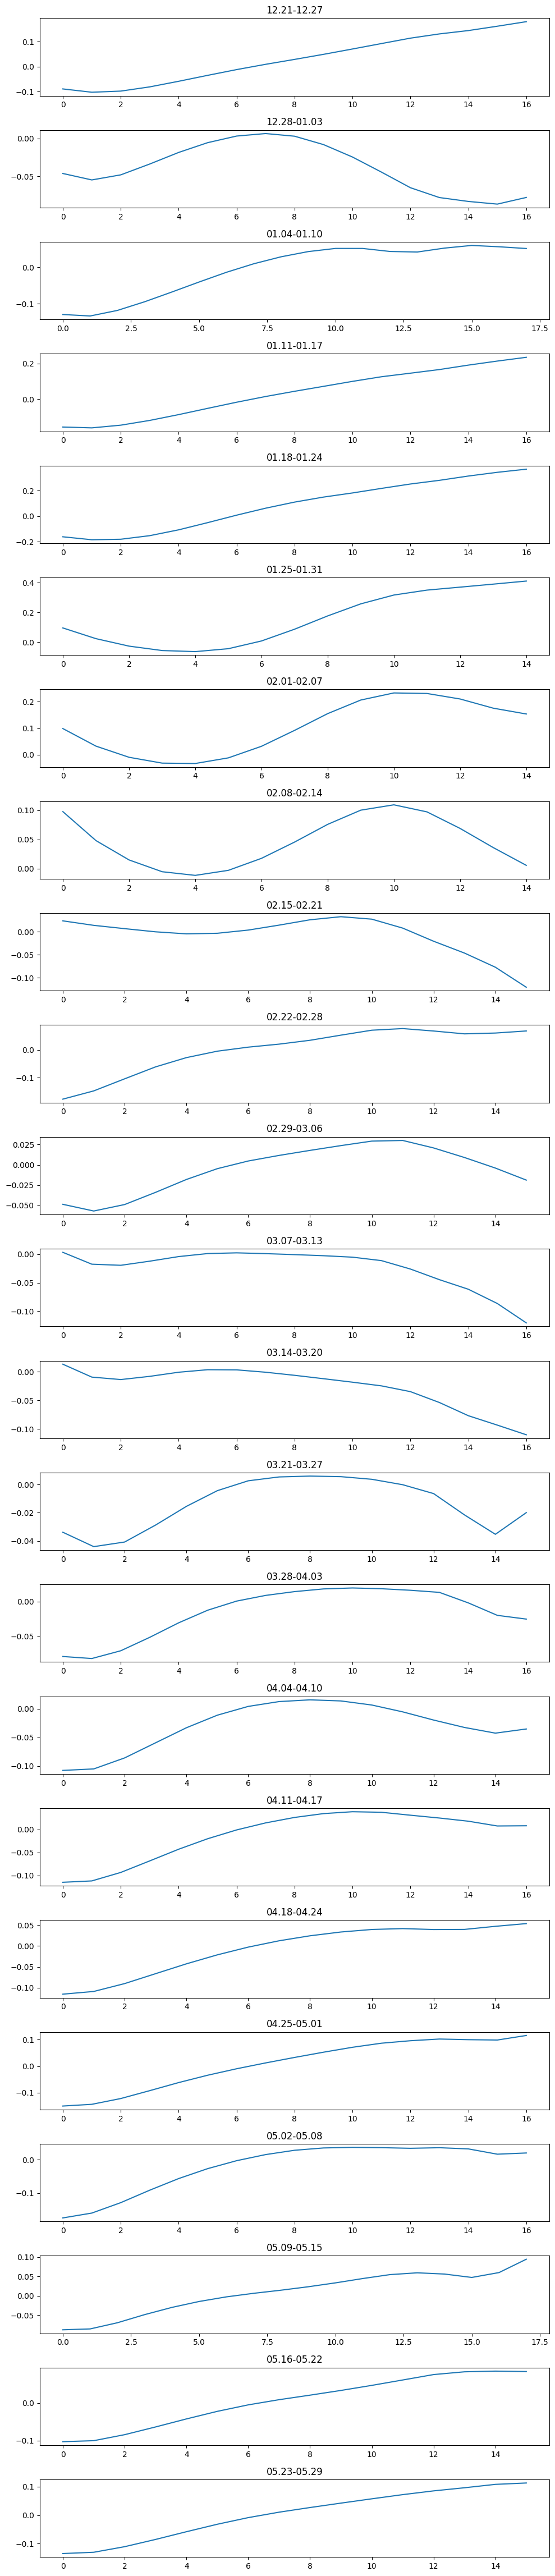

In [44]:
start_date = datetime(2019, 12, 21)
fig, axs = plt.subplots(len(ALE), 1, figsize=(10, 46))  # 23 plots, each in its row
for i, ax in enumerate(axs):
    
    ax.plot(ALE[i])
    
    date_range_start = start_date + timedelta(days=i*7)
    date_range_end = date_range_start + timedelta(days=6)
    ax.set_title(f'{date_range_start.strftime("%m.%d")}-{date_range_end.strftime("%m.%d")}')

plt.tight_layout()
plt.show()

In [21]:
max_length = max(len(arr) for arr in ALE)

# Initializing a new list to hold the padded arrays
ALE_padded = []

for arr in ALE:
    padded_arr = np.full(max_length, np.nan)  # Fill with NaNs
    padded_arr[:len(arr)] = arr  # Replace the beginning of the padded array with the original array's data
    ALE_padded.append(padded_arr)

In [32]:
max_val = max(np.nanmax(arr) for arr in ALE)
min_val = min(np.nanmin(arr) for arr in ALE)
print(min_val, max_val)

midpoint = abs(min_val) / (abs(max_val) + abs(min_val))
colors = [(0, "blue"), (midpoint, "white"), (1, "red")]
linear_cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)
linear_cmap.set_bad("lightgray")

-0.18451681103418918 0.4106844637284013


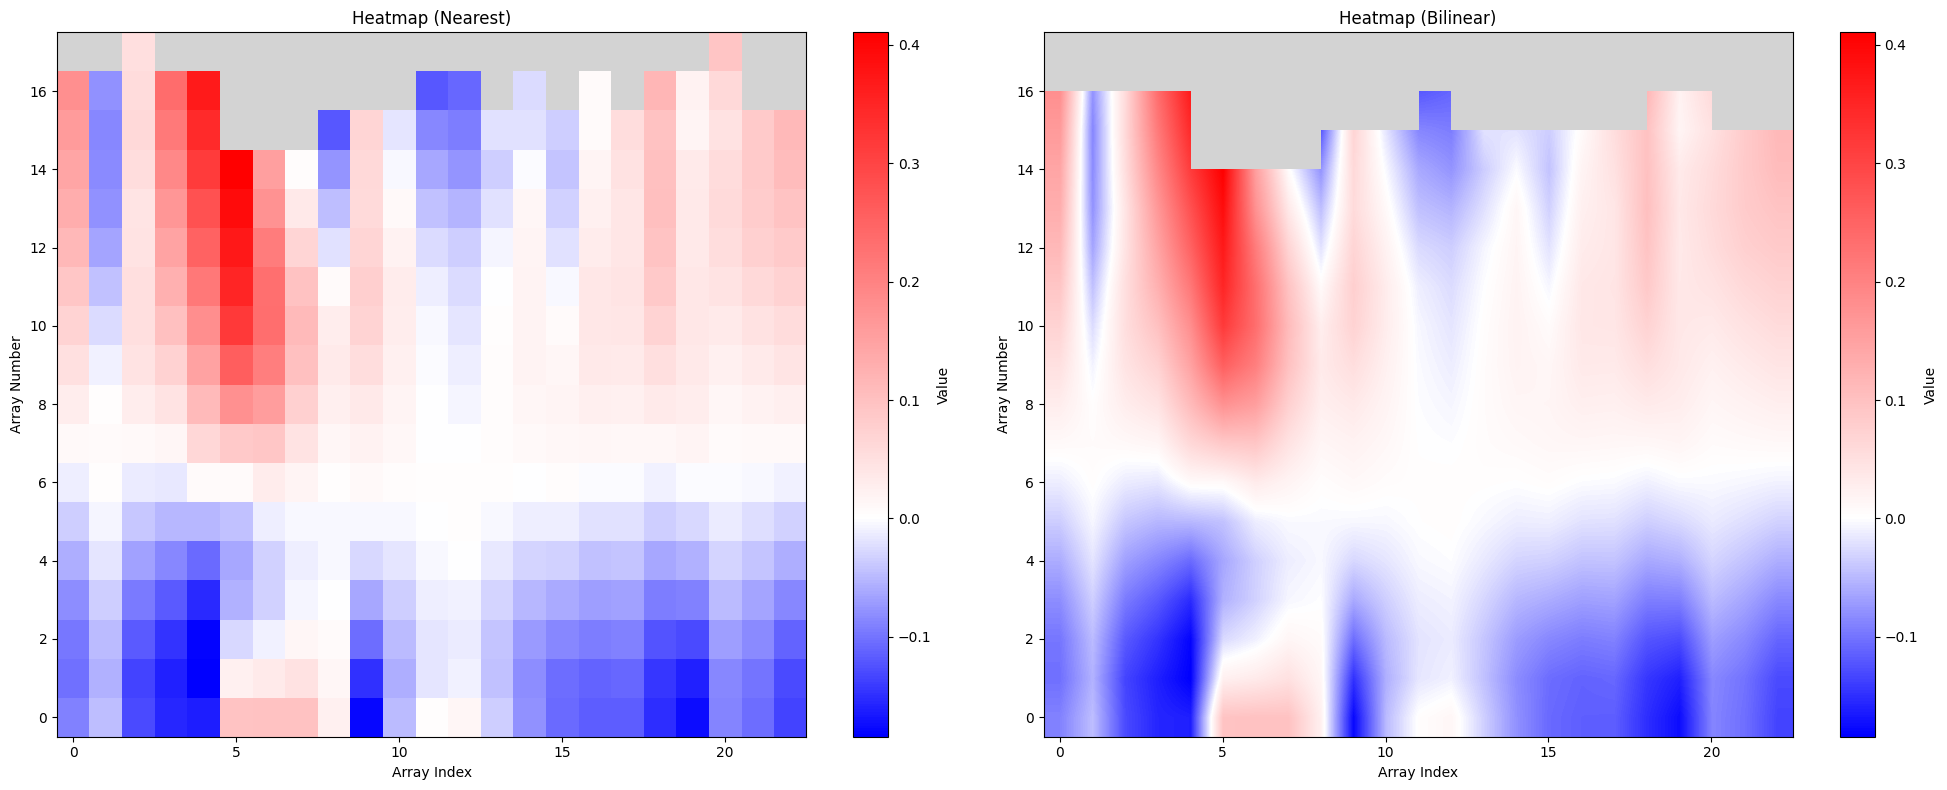

In [40]:
ALE_padded_matrix = np.array(ALE_padded)

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
# Plotting the heatmap with NaNs showing as a different color (usually white or light)
axs[0].imshow(ALE_padded_matrix.T, aspect='auto', cmap=linear_cmap, origin='lower', vmin=min_val, vmax=max_val, interpolation='nearest')
axs[0].set_title('Heatmap (Nearest)')
axs[0].set_xlabel('Array Index')
axs[0].set_ylabel('Array Number')

# Adding colorbar to the first plot
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mcolors.Normalize(vmin=min_val, vmax=max_val), cmap=linear_cmap), ax=axs[0], orientation='vertical')
cbar.set_label('Value')

# Plot with 'bilinear' interpolation
axs[1].imshow(ALE_padded_matrix.T, aspect='auto', cmap=linear_cmap, origin='lower', vmin=min_val, vmax=max_val, interpolation='bilinear')
axs[1].set_title('Heatmap (Bilinear)')
axs[1].set_xlabel('Array Index')
axs[1].set_ylabel('Array Number')

# Adding colorbar to the second plot
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mcolors.Normalize(vmin=min_val, vmax=max_val), cmap=linear_cmap), ax=axs[1], orientation='vertical')
cbar.set_label('Value')

plt.tight_layout()
plt.show()

In [10]:
week_predictions_array = np.zeros_like(prediction)
dummy_treat = dataset['treatments'][:,:,conformity_index]
dummy_treat = np.clip(dummy_treat+1, None, np.max(dummy_treat))

for i in range(0, length, 7):
    start = i
    end = i+7 if i+7<length else length
    week_data = copy.deepcopy(dataset)——
    weel_data['treatments'][:, start:end, conformity_index] = dummy_treat[:,start:end]
    
    week_predictions, _ = rnn_predict(dataset=week_data, MODEL_ROOT=MODEL_ROOT, b_use_predicted_confounders=True)
    week_predictions_array[:, i] = week_predictions[:, i]

INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 1559it [00:43, 35.78it/s]


KeyboardInterrupt: 

In [9]:
dataset

{'covariates': array([[[ 0.0000000e+00, -1.7031363e-01, -1.4140126e+00, ...,
          -1.0077499e+00, -3.3466887e-01, -3.1778625e-01],
         [ 0.0000000e+00, -1.7031363e-01, -1.4140126e+00, ...,
          -1.0077499e+00, -7.1619369e-02, -3.1778625e-01],
         [ 0.0000000e+00, -1.7031363e-01, -1.4140126e+00, ...,
          -1.0077499e+00, -1.6727377e-01, -3.1778625e-01],
         ...,
         [ 0.0000000e+00, -1.7031363e-01, -1.4140126e+00, ...,
          -1.0077499e+00,  1.7219025e+00, -3.1778625e-01],
         [ 0.0000000e+00, -1.7031363e-01, -1.4140126e+00, ...,
          -1.0077499e+00,  1.2436301e+00,  5.1915946e+00],
         [ 0.0000000e+00, -1.7031363e-01, -1.4140126e+00, ...,
           1.5195643e+00,  1.8414706e+00, -2.9506713e-01]],
 
        [[ 1.0000000e+00, -1.7031363e-01, -1.4140126e+00, ...,
           1.6713912e+00, -3.3466887e-01, -3.1778625e-01],
         [ 1.0000000e+00, -1.7031363e-01, -1.4140126e+00, ...,
           1.5585287e+00, -7.1619369e-02, -3.1778625

#### 政策阶段的二阶ALE

In [58]:
# 时间节点
start_date = pd.Timestamp('2019-12-21')
categorization_dates = pd.to_datetime(
            ['2020-01-19','2020-01-23', '2020-02-07', '2020-02-10', '2020-02-17', '2020-02-23', '2020-03-21', '2020-03-29', '2020-05-09']
        )
# 计算每个分类日期对应于开始日期的第几天
days_from_start = (categorization_dates - start_date).days
days_from_start.tolist()

[29, 33, 48, 51, 58, 64, 91, 99, 140]

In [60]:
days_intervals_start = [0] + days_from_start.tolist()
days_intervals_start

[0, 29, 33, 48, 51, 58, 64, 91, 99, 140]

In [61]:
days_intervals_start = [0] + days_from_start.tolist()
days_intervals_end = days_from_start.tolist() + [length]

raw_predictions, observations = rnn_predict(dataset=dataset, MODEL_ROOT=MODEL_ROOT, b_use_predicted_confounders=True)
interval_predictions_array = np.zeros_like(raw_predictions)

# 遍历每个时间区间，获取对应时间区间的数据
for start, end in zip(days_intervals_start, days_intervals_end):
    # 获取对应时间区间的数据
    interval_data = copy.deepcopy(dataset)
    interval_data['treatments'][:, start:end, :] += 1
    interval_predictions, _ = rnn_predict(dataset=interval_data, MODEL_ROOT=MODEL_ROOT, b_use_predicted_confounders=True)
    interval_predictions_array[:, start:end] = interval_predictions[:, start:end]

INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 17.51it/s]
INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 16.05it/s]
INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 17.16it/s]
INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 17.09it/s]
INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 15.89it/s]
INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 16.71it/s]
INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 16.06it/s]
INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 16.46it/s]
INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 16.85it/s]
INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 16.87it/s]
INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 17.01it/s]


In [62]:
effects = interval_predictions_array - raw_predictions
effects.shape

(1000, 161, 1)

In [64]:
# days_intervals_start = [0] + days_from_start
days_intervals_end

[29, 33, 48, 51, 58, 64, 91, 99, 140, 161]

(1000, 29, 3)
(1000, 29, 1)
(1000, 4, 3)
(1000, 4, 1)
(1000, 15, 3)
(1000, 15, 1)
(1000, 3, 3)
(1000, 3, 1)
(1000, 7, 3)
(1000, 7, 1)
(1000, 6, 3)
(1000, 6, 1)
(1000, 27, 3)
(1000, 27, 1)
(1000, 8, 3)
(1000, 8, 1)
(1000, 41, 3)
(1000, 41, 1)
(1000, 21, 3)
(1000, 21, 1)


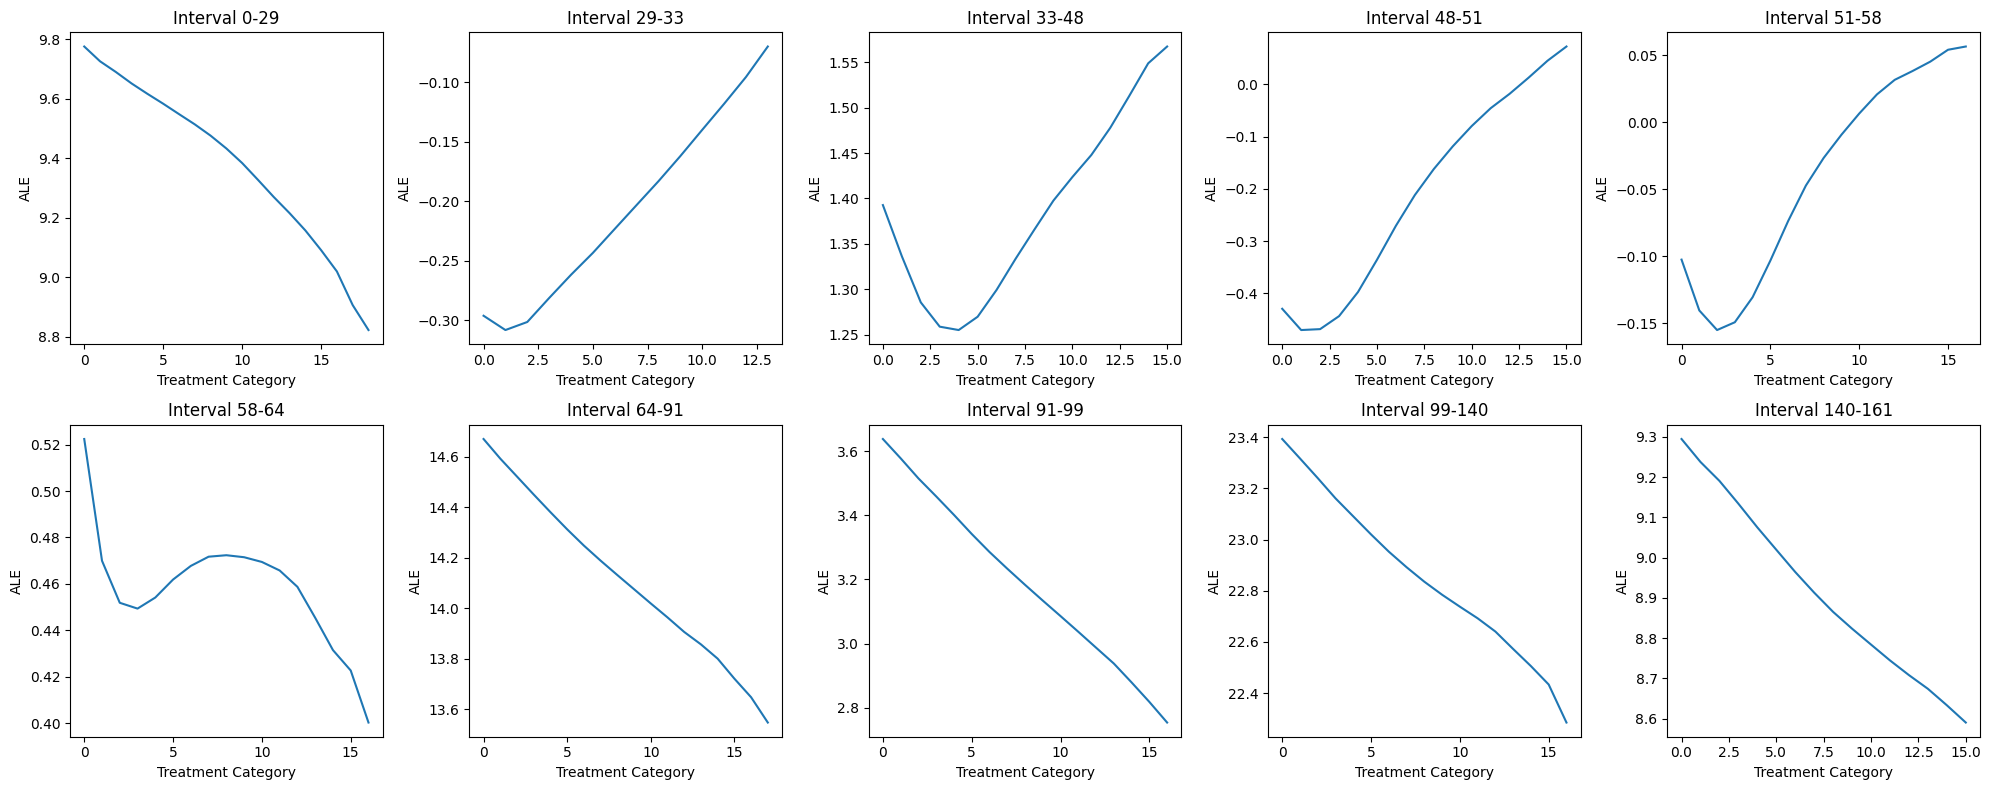

In [65]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
effects = interval_predictions_array - raw_predictions

for i, (start, end) in enumerate(zip(days_intervals_start, days_intervals_end)):
    dataset1 = interval_data['treatments'][:, start:end, :]
    print(dataset1.shape)
    effect1 = effects[:,start:end,:]
    print(effect1.shape)
    index_groupby = pd.DataFrame({"index": dataset1[:,:,conformity_index].flatten(), "effects": effect1.flatten()}).groupby(
            "index")
    mean_effects = index_groupby.mean().to_numpy().flatten()
    ale = np.array([0, *np.cumsum(mean_effects)])
    ale = (ale[1:] + ale[:-1]) / 2
    ale -= np.sum(ale * index_groupby.size() / num_samples)
    
    ax = axs[i // 5, i % 5]
    ax.plot(ale)
    ax.set_title(f'Interval {start}-{end}')
    ax.set_xlabel('Treatment Category')
    ax.set_ylabel('ALE')

plt.tight_layout()
plt.show()

In [49]:
dataset1[:,:,conformity_index].flatten().shape

(132000,)

In [113]:
observations = dataset["outcomes"]

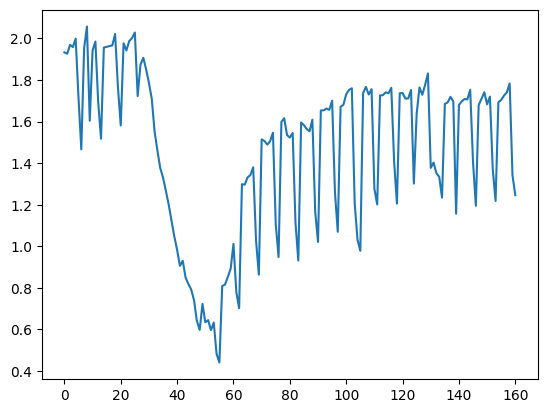

In [114]:
plt.plot(np.mean(observations, axis=0))

Text(0.5, 1.0, 'Prediction')

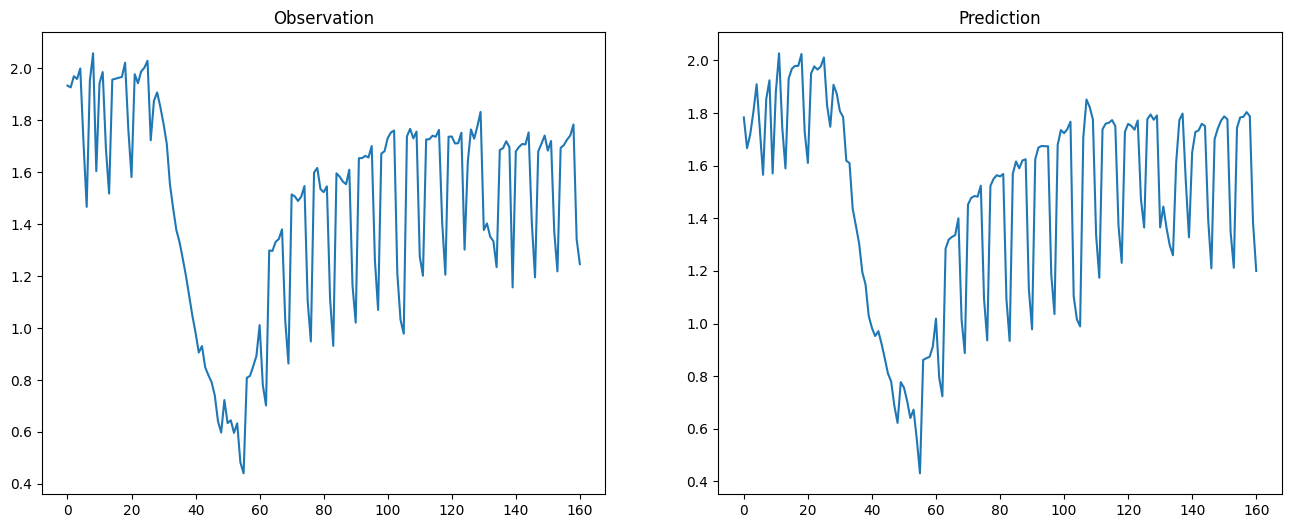

In [117]:
fig, ax = plt.subplots(1,2, figsize=(16, 6))
ax[0].plot(np.mean(observations, axis=0))
# ax[0].set_ylim([0.5,4.5])
ax[0].set_title("Observation")
ax[1].plot(np.mean(prediction1, axis=0))
# ax[1].set_ylim([0.5,4.5])
ax[1].set_title("Prediction")

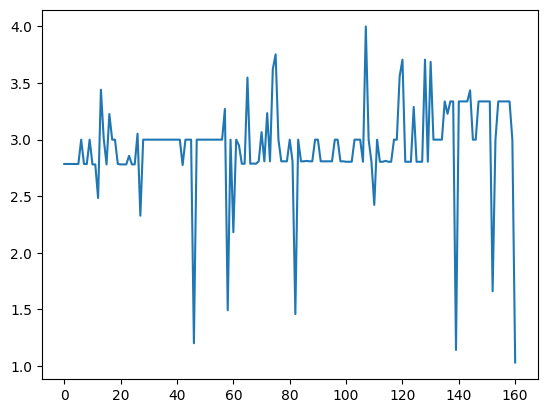

In [86]:
history = pd.read_csv("results/rmsn_all_data_use_confounders_True/rnn_propensity_weighted/history.csv")

Text(0.5, 0, 'Epochs')

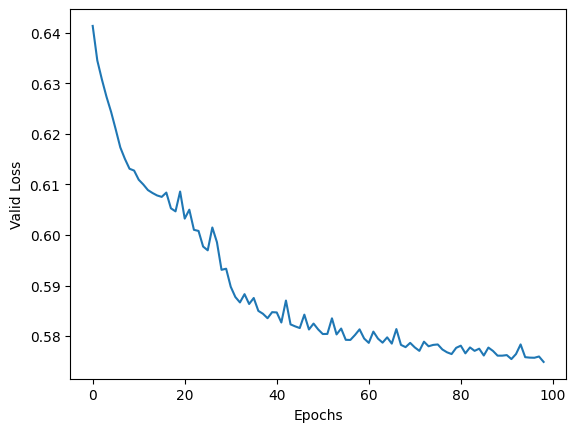

In [90]:
plt.plot(history['valid_loss'])
plt.ylabel("Valid Loss")
plt.xlabel("Epochs")

#### 从众效应如何助推政策

In [8]:
conformity_index = 0
lock_index = 1
open_index = 2

In [12]:
sci_treatment = dataset['treatments'][...,conformity_index]
bins = 20
# sci值分箱
quantiles = np.unique(
        np.quantile(
            sci_treatment, np.linspace(0, 1, bins + 1), interpolation="lower"
        )
    )
print(quantiles)

indices = np.clip(
        np.digitize(sci_treatment, quantiles, right=True) - 1, 0, None
    )

/tmp/ipykernel_1301/2017285486.py:5: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  np.quantile(


[ 0.         2.7839487  3.2102568  3.4921846  3.7120304  3.89713
  4.0599647  4.208198   4.3470216  4.481213   4.612237   4.7426696
  4.8763485  5.016597   5.168876   5.339695   5.5409446  5.7891464
  6.1163     6.6040506 12.502842 ]


In [13]:
# policy = 1（两个政策都存在的情况）
Policy_Predictions = []
for offset in range(2):
    dataset_replic = copy.deepcopy(dataset)
    dataset_replic['treatments'][...,conformity_index] = quantiles[indices + offset]
    predictions = rnn_predict(dataset=dataset_replic, MODEL_ROOT=MODEL_ROOT, b_use_predicted_confounders=True)
    Policy_Predictions.append(predictions)

INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 0it [00:00, ?it/s]2024-04-02 16:33:50.294688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
Predicting rnn_propensity_weighted: 5113it [02:25, 35.18it/s]
INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 5113it [02:16, 37.39it/s]


In [14]:
# 令限制政策等于0
No_Lock_Predictions = []
for offset in range(2):
    dataset_replic = copy.deepcopy(dataset)
    dataset_replic['treatments'][...,lock_index] = 0
    dataset_replic['treatments'][...,conformity_index] = quantiles[indices + offset]
    predictions = rnn_predict(dataset=dataset_replic, MODEL_ROOT=MODEL_ROOT, b_use_predicted_confounders=True)
    No_Lock_Predictions.append(predictions)

INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 5113it [02:19, 36.62it/s]
INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 5113it [02:20, 36.32it/s]


In [15]:
# 令开放政策等于0
No_Open_Predictions = []
for offset in range(2):
    dataset_replic = copy.deepcopy(dataset)
    dataset_replic['treatments'][...,open_index] = 0
    dataset_replic['treatments'][...,conformity_index] = quantiles[indices + offset]
    predictions = rnn_predict(dataset=dataset_replic, MODEL_ROOT=MODEL_ROOT, b_use_predicted_confounders=True)
    No_Open_Predictions.append(predictions)

INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 5113it [02:19, 36.77it/s]
INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 5113it [02:23, 35.60it/s]


In [62]:
# 令SCI直接等于0
Sci_Predictions = []

for sci_var in range(2):
    for policy_var in range(2):
        dataset_replic = copy.deepcopy(dataset)
        if sci_var==0:
            dataset_replic['treatments'][...,conformity_index] = 0
        if policy_var==0:
            dataset_replic['treatments'][...,lock_index] = policy_var
        predictions, _ = rnn_predict(dataset=dataset_replic, MODEL_ROOT=MODEL_ROOT, b_use_predicted_confounders=True)
        Sci_Predictions.append(predictions)

INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 5113it [02:18, 37.01it/s]
INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 5113it [02:16, 37.32it/s]
INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 5113it [02:39, 31.97it/s]
INFO:Physical devices cannot be modified after being initialized


results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_all_data_v2_use_confounders_True/rnn_propensity_weighted/rnn_propensity_weighted_0.1_145_100_64_0.005_1.0_60_optimal
Predicting rnn_propensity_weighted: 5113it [02:17, 37.08it/s]


In [28]:
# 先看封锁政策，获得4个预测序列

# 1. 有政策，低sci
lock_lowsci_preds, _ = Policy_Predictions[0]
# 2. 有政策，高sci
lock_highsci_preds, _ = Policy_Predictions[1]
# 3. 无政策，低sci
nolock_lowsci_preds, _ = No_Lock_Predictions[0]
# 4. 无政策，高sci
nolock_highsci_preds, _ = No_Lock_Predictions[1]

In [63]:
# 1. 无政策，无sci
nolock_nosci_preds = Sci_Predictions[0]
# 2. 有政策，无sci
lock_nosci_preds = Sci_Predictions[1]
# 3. 无政策，有sci
nolock_sci_preds = Sci_Predictions[2]
# 4. 有政策，有sci
lock_sci_preds = Sci_Predictions[3]

In [40]:
from datetime import datetime

date_format = "%Y%m%d"
data_start_date = "20191221"
lock_start_date = "20200124"
lock_end_date = "20200223"

# 计算日期差
start_date = datetime.strptime(data_start_date, date_format)
begin_date = datetime.strptime(lock_start_date, date_format)
end_date = datetime.strptime(lock_end_date, date_format)

begin_index = (begin_date - start_date).days
end_index = (end_date - start_date).days

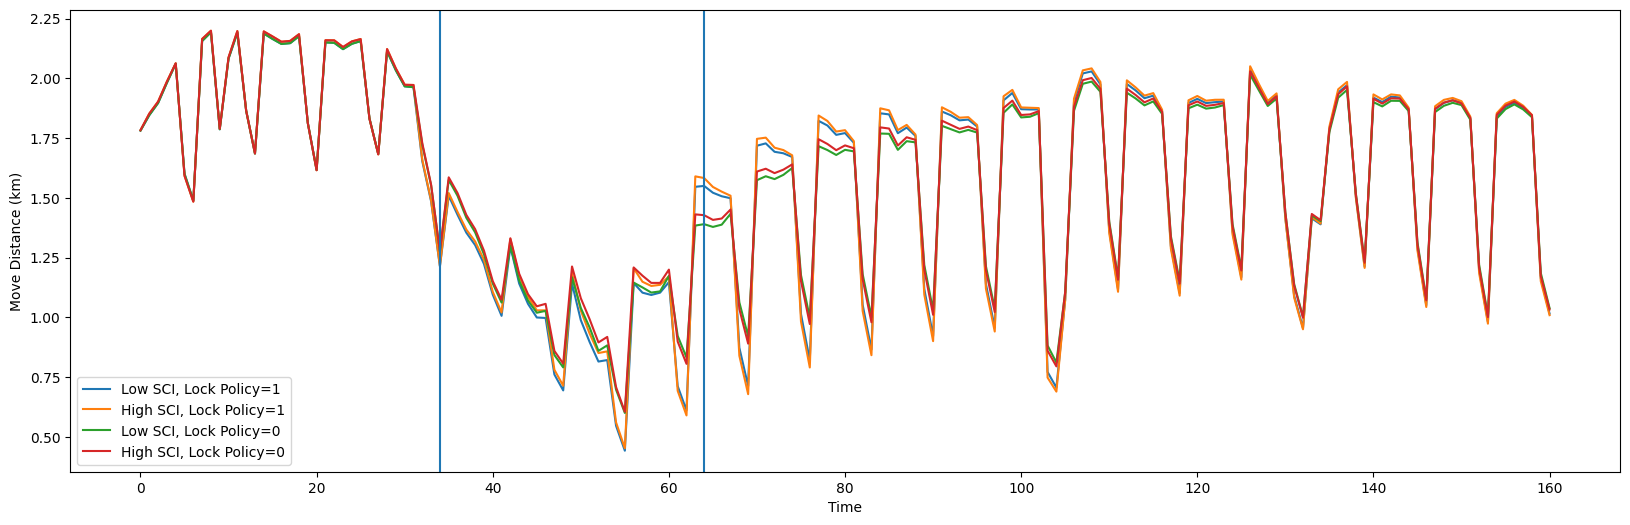

In [53]:
# 画图，4条线画一起
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(np.mean(lock_lowsci_preds, axis=0), label="Low SCI, Lock Policy=1")
ax.plot(np.mean(lock_highsci_preds, axis=0), label="High SCI, Lock Policy=1")

ax.plot(np.mean(nolock_lowsci_preds, axis=0), label="Low SCI, Lock Policy=0")
ax.plot(np.mean(nolock_highsci_preds, axis=0), label="High SCI, Lock Policy=0")

ax.axvline(x=begin_index)
ax.axvline(x=end_index)
ax.set_xlabel("Time")
ax.set_ylabel("Move Distance (km)")
ax.legend()

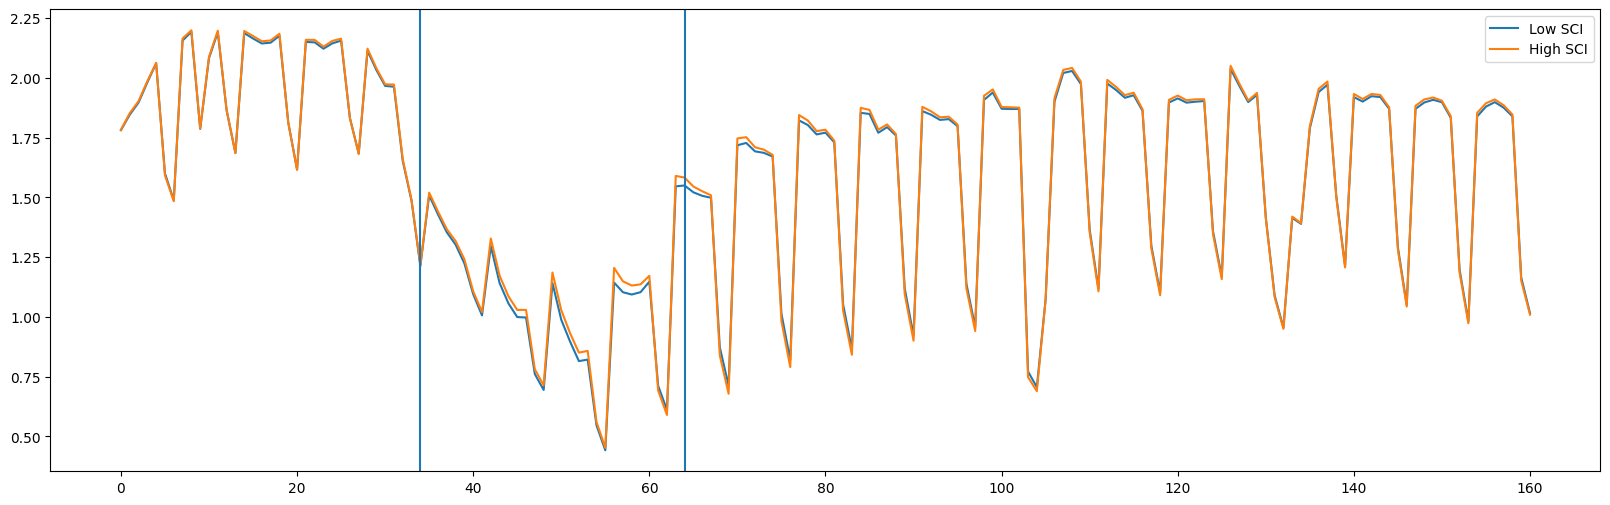

In [68]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(np.mean(lock_lowsci_preds, axis=0), label="Low SCI")
ax.plot(np.mean(lock_highsci_preds, axis=0), label="High SCI")

ax.axvline(x=begin_index)
ax.axvline(x=end_index)
ax.legend()

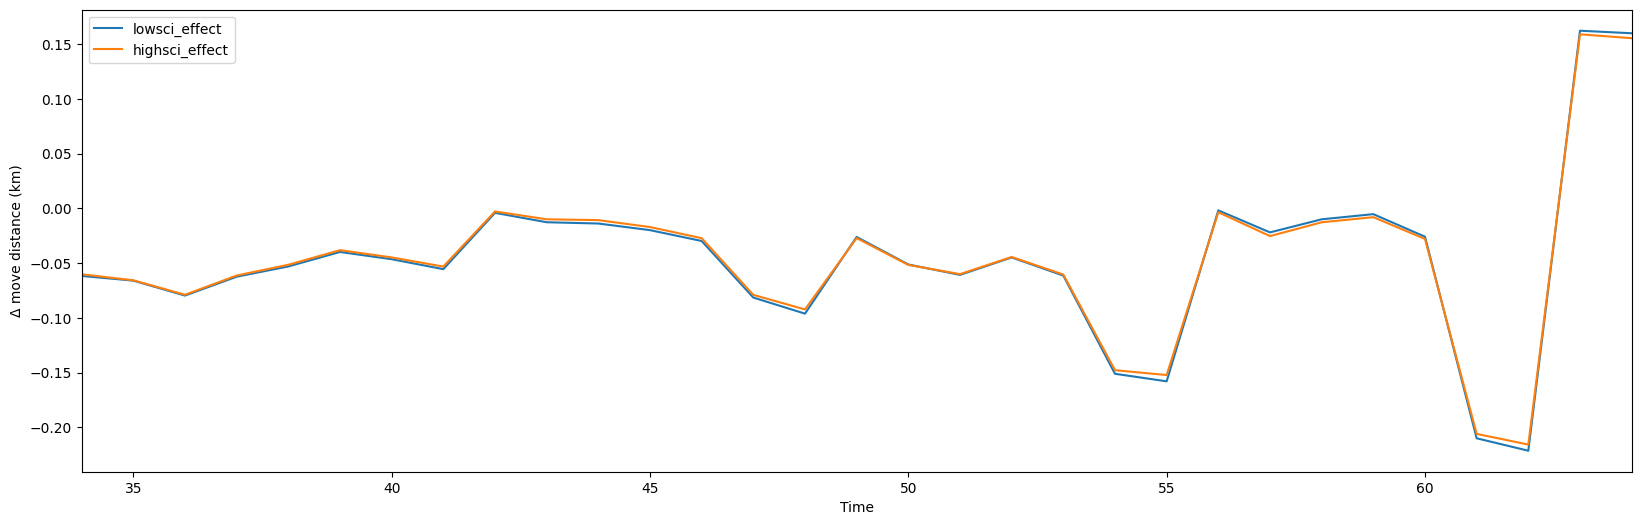

In [54]:
# 政策效应曲线
# 低sci
low_sci_effect = lock_lowsci_preds - nolock_lowsci_preds
# 高sci
high_sci_effect = lock_highsci_preds - nolock_highsci_preds

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(np.mean(low_sci_effect, axis=0), label="lowsci_effect")
ax.plot(np.mean(high_sci_effect, axis=0), label="highsci_effect")

ax.set_xlim([begin_index, end_index])
ax.set_xlabel("Time")
ax.set_ylabel("Δ move distance (km)")
ax.legend()

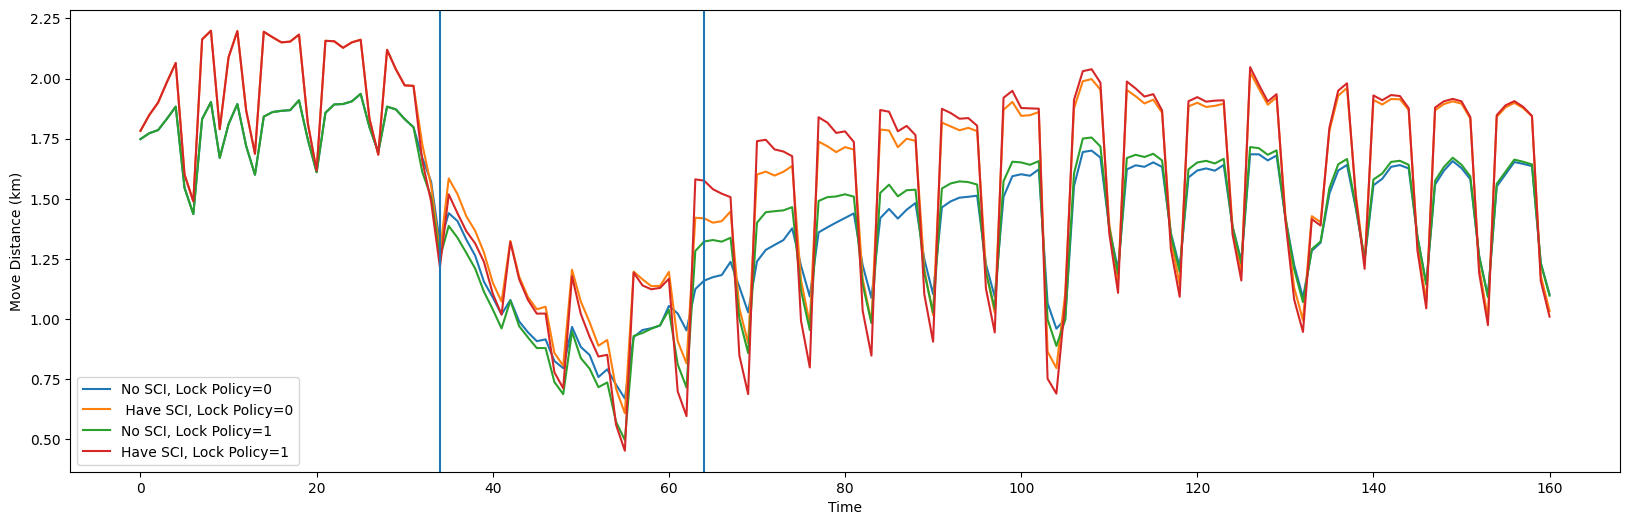

In [64]:
# 画图，4条线画一起
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(np.mean(nolock_nosci_preds, axis=0), label="No SCI, Lock Policy=0")
ax.plot(np.mean(nolock_sci_preds, axis=0), label=" Have SCI, Lock Policy=0")

ax.plot(np.mean(lock_nosci_preds, axis=0), label="No SCI, Lock Policy=1")
ax.plot(np.mean(lock_sci_preds, axis=0), label="Have SCI, Lock Policy=1")

ax.axvline(x=begin_index)
ax.axvline(x=end_index)
ax.set_xlabel("Time")
ax.set_ylabel("Move Distance (km)")
ax.legend()

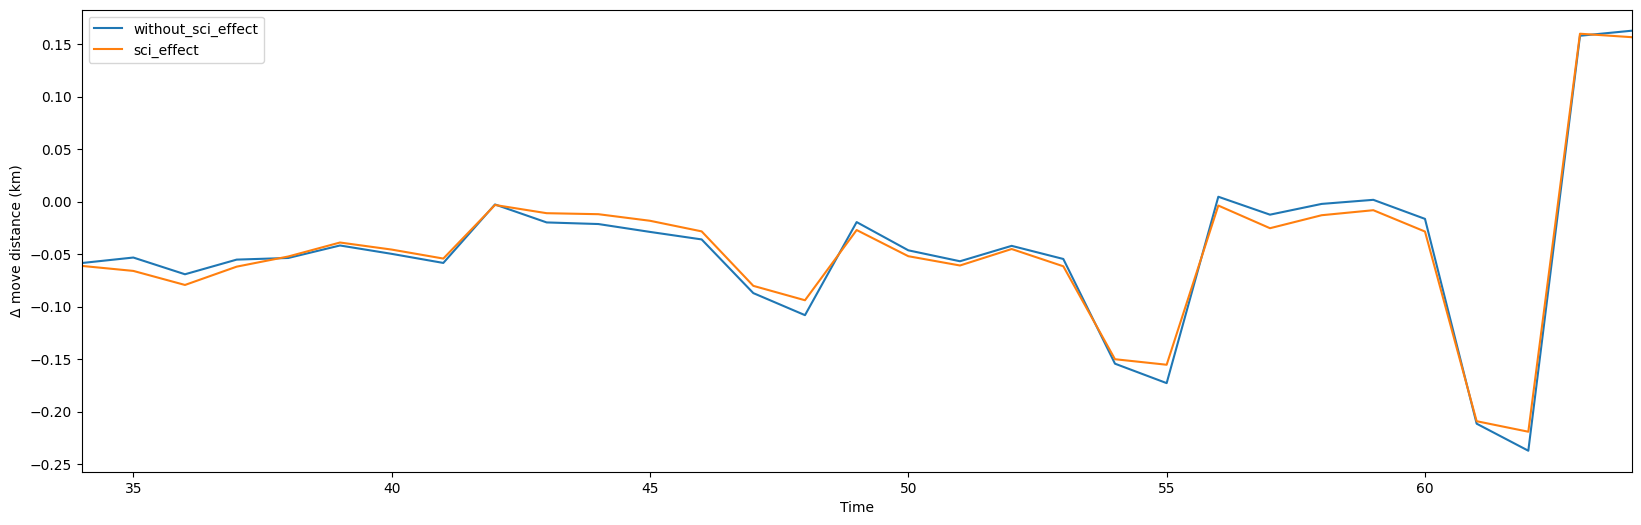

In [67]:
# 政策效应曲线
# 无sci
no_sci_effect = np.mean(lock_nosci_preds,axis=0) - np.mean(nolock_nosci_preds,axis=0)
# 有sci
sci_effect = np.mean(lock_sci_preds,axis=0) - np.mean(nolock_sci_preds,axis=0)

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(no_sci_effect, label="without_sci_effect")
ax.plot(sci_effect, label="sci_effect")

ax.set_xlim([begin_index, end_index])
ax.set_xlabel("Time")
ax.set_ylabel("Δ move distance (km)")
ax.legend()